# Business Understanding

*Para la comprensión del negocio, se sugiere consultar los notebooks 2.0, 2.5 y 3.0.*

---

# Data Understanding

*Para la comprensión de los datos, se sugiere consultar los notebooks 2.0, 2.5 y 3.0.*

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.linear_model import BayesianRidge, LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

## Importación data

### Datos Geo-X
Data pre-procesada y consolidada de los registros obtenidos por Geo-X a través de los nodos de las pilas de lixiviación.
* Sin tratamiento de nulos.
* Pivoteada para agrupar los valores de los distintas medidas por Epoch (UTC-0)

In [ ]:
pd.read_csv("../dataset/processed/all_nodes_2.csv")

,Epoch,Node,Humedad 1,Humedad 2,Temperatura 1,Temperatura 2,pH
0,2023-10-24 19:58:57,A1,0.0,0.0,50.7,49.3,7.84
1,2023-10-24 19:59:56,A1,0.0,0.0,50.8,49.4,7.84
2,2023-10-24 20:00:56,A1,0.0,0.0,50.8,49.4,7.83
3,2023-10-24 20:01:56,A1,0.0,0.0,50.6,49.4,7.83
4,2023-10-24 20:02:27,A1,0.0,0.0,50.5,49.4,7.83
...,...,...,...,...,...,...,...
412508,2024-01-18 17:01:56,D4,24.5,18.8,23.2,22.5,NaN
412509,2024-01-18 17:02:56,D4,24.5,18.8,23.2,22.5,NaN
412510,2024-01-18 17:03:56,D4,24.5,18.8,23.2,22.5,NaN
412511,2024-01-18 17:06:56,D4,24.5,18.8,23.2,22.5,NaN


In [ ]:
df_geox = pd.read_csv("../dataset/processed/all_nodes_2.csv", 
                      parse_dates=["Epoch"], 
                      index_col="Epoch")

In [4]:
df_geox.head()

,Node,Humedad 1,Humedad 2,Temperatura 1,Temperatura 2,pH
Epoch,,,,,,
2023-10-24 19:58:57,A1,0.0,0.0,50.7,49.3,7.84
2023-10-24 19:59:56,A1,0.0,0.0,50.8,49.4,7.84
2023-10-24 20:00:56,A1,0.0,0.0,50.8,49.4,7.83
2023-10-24 20:01:56,A1,0.0,0.0,50.6,49.4,7.83
2023-10-24 20:02:27,A1,0.0,0.0,50.5,49.4,7.83


### Datos cliente
Data consolidada pre-procesada de los registros obtenidos manualmente por el cliente de la solución de lixiviación.
* Sin tratamiento de nulos en columnas de medición.
* Timestamp (UTC-3)

In [ ]:
pd.read_csv("../dataset/processed/solution_data.csv")

,Timestamp,Cu,pH
0,2023-10-27 10:00:00,NaN,NaN
1,2023-10-27 13:00:00,NaN,NaN
2,2023-10-27 16:00:00,16.76,1.15
3,2023-10-27 19:00:00,35.51,2.57
4,2023-10-27 22:00:00,30.16,2.22
...,...,...,...
520,2024-01-13 10:00:00,0.19,1.56
521,2024-01-13 13:00:00,NaN,NaN
522,2024-01-13 16:00:00,NaN,NaN
523,2024-01-13 19:00:00,NaN,NaN


In [ ]:
df_client = pd.read_csv("../dataset/processed/solution_data.csv",
                        parse_dates=["Timestamp"], 
                        index_col="Timestamp")

In [7]:
df_client.head()

,Cu,pH
Timestamp,,
2023-10-27 10:00:00,NaN,NaN
2023-10-27 13:00:00,NaN,NaN
2023-10-27 16:00:00,16.76,1.15
2023-10-27 19:00:00,35.51,2.57
2023-10-27 22:00:00,30.16,2.22


---

## Concatenación de DataFrames de Geo-X y de cliente

### Modificar nombre de columnas
Para identificar el origen de cada una en el DataFrame concatenado

In [8]:
df_geox_2 = df_geox.copy()
df_client_2 = df_client.copy()

df_geox_2.columns = [f"geox_{col}" for col in df_geox_2.columns]
df_client_2.columns = [f"client_{col}" for col in df_client_2.columns]

### Cambiar Timestamp de cliente a UTC-0
Para que el timestamp de cada DataFrame esté en un mismo UTC

In [9]:
df_client_2.index = df_client_2.index- pd.Timedelta(hours=3)
df_client_2.head()

,client_Cu,client_pH
Timestamp,,
2023-10-27 07:00:00,NaN,NaN
2023-10-27 10:00:00,NaN,NaN
2023-10-27 13:00:00,16.76,1.15
2023-10-27 16:00:00,35.51,2.57
2023-10-27 19:00:00,30.16,2.22


In [10]:
# Cambiar nombre del índice de cada DataFrame
df_geox_2.index.name = "geox_UTC_0"
df_client_2.index.name = "client_UTC_0"

In [11]:
df_geox_2.head()

,geox_Node,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,geox_pH
geox_UTC_0,,,,,,
2023-10-24 19:58:57,A1,0.0,0.0,50.7,49.3,7.84
2023-10-24 19:59:56,A1,0.0,0.0,50.8,49.4,7.84
2023-10-24 20:00:56,A1,0.0,0.0,50.8,49.4,7.83
2023-10-24 20:01:56,A1,0.0,0.0,50.6,49.4,7.83
2023-10-24 20:02:27,A1,0.0,0.0,50.5,49.4,7.83


### Definir intervalo de ventana de tiempo para concatenar ambos DataFrame

In [12]:
print("Valores únicos de hora en índice de df_client_2:")
df_client_2.index.hour.value_counts()

Valores únicos de hora en índice de df_client_2:


client_UTC_0
7     66
10    66
13    66
16    66
19    65
22    65
1     65
4     65
21     1
Name: count, dtype: int64

La ventana de tiempo en el conjunto de datos del cliente es de 3 horas. Sin embargo, hay un registro cuya hora de medición es distina: 21

In [13]:
print("Filas en que la hora del índice es igual a 21 en df_client_2:") 
df_client_2[df_client_2.index.hour == 21]

Filas en que la hora del índice es igual a 21 en df_client_2:


,client_Cu,client_pH
client_UTC_0,,
2023-12-16 21:00:00,0.6,1.65


### Ámbito temporal de los conjuntos de datos (en UTC 0)

In [14]:
print(f"Primera fecha de df_geox_2: {df_geox_2.index.min()}")
print(f"Última fecha de df_geox_2: {df_geox_2.index.max()}\n")
print(f"Primera fecha de df_client_2: {df_client_2.index.min()}")
print(f"Última fecha de df_client_2: {df_client_2.index.max()}")

Primera fecha de df_geox_2: 2023-10-24 19:56:58
Última fecha de df_geox_2: 2024-01-18 17:13:18

Primera fecha de df_client_2: 2023-10-27 07:00:00
Última fecha de df_client_2: 2024-01-13 19:00:00


El ámbito temporal general, entre los dos DataFrames, es desde el 24-10-2023 al 18-10-2024, por lo que se toman esas fechas para generar las ventanas de 3 horas, a partir de la primera a las 19 horas hasta la última a las 19 horas.

In [15]:
start_time = pd.to_datetime("2023-10-24 19:00:00")
end_time = pd.to_datetime("2024-01-18 19:00:00")
window_size = pd.Timedelta(hours=3)

windows = pd.date_range(start=start_time, 
                        end=end_time, 
                        freq=window_size)

In [16]:
df_concat = pd.DataFrame(index=windows)

Se comprueba si es que el índice del DataFrame generado se ajusta al intervalo de tiempo total definido anteriormente

In [17]:
df_concat

""
2023-10-24 19:00:00
2023-10-24 22:00:00
2023-10-25 01:00:00
2023-10-25 04:00:00
2023-10-25 07:00:00
...
2024-01-18 07:00:00
2024-01-18 10:00:00
2024-01-18 13:00:00
2024-01-18 16:00:00


### Agrupar valores de df_geox_2 por ventanas de tiempo

Se agrupan los valores de df_geox_2 según las ventanas de tiempo y el ámbito total definido anteriormente. Se agrupan en listas, para después poder hacer cálculos sobre éstas según se requiera. 

In [18]:
df_geox_grouped = df_geox_2.groupby(
    pd.cut(df_geox_2.index, bins=windows)).agg(list)

C:\Users\piano\AppData\Local\Temp\ipykernel_11848\4205384480.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_geox_grouped = df_geox_2.groupby(


El resultado es un DataFrame cuyo índice indica el intervalo de cada ventana, con el primer valor incluyente *(* y el último excluyente *]*

In [19]:
df_geox_grouped.head()

,geox_Node,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,geox_pH
"(2023-10-24 19:00:00, 2023-10-24 22:00:00]","[A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[50.7, 50.8, 50.8, 50.6, 50.5, 49.6, 49.5, 49....","[49.3, 49.4, 49.4, 49.4, 49.4, 49.0, 49.0, 49....","[7.84, 7.84, 7.83, 7.83, 7.83, 7.82, 7.82, 7.8..."
"(2023-10-24 22:00:00, 2023-10-25 01:00:00]","[A1, A1, A1, A1, A3, A3]","[1.5, 1.5, 1.5, 1.5, 3.2, 3.2]","[5.3, 5.3, 5.3, 5.3, 3.2, 3.2]","[34.8, 34.8, 34.8, 34.8, 38.0, 38.1]","[36.3, 36.3, 36.3, 36.3, 39.4, 39.4]","[5.79, 5.78, 5.81, 5.81, nan, nan]"
"(2023-10-25 01:00:00, 2023-10-25 04:00:00]",[],[],[],[],[],[]
"(2023-10-25 04:00:00, 2023-10-25 07:00:00]",[],[],[],[],[],[]
"(2023-10-25 07:00:00, 2023-10-25 10:00:00]",[],[],[],[],[],[]


### Agrupar valores de df_client_2 por ventanas de tiempo

In [20]:
df_client_grouped = df_client_2.groupby(
    pd.cut(df_client_2.index, bins=windows)).agg(list)

C:\Users\piano\AppData\Local\Temp\ipykernel_11848\1636115311.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_client_grouped = df_client_2.groupby(


In [21]:
df_client_grouped

,client_Cu,client_pH
"(2023-10-24 19:00:00, 2023-10-24 22:00:00]",[],[]
"(2023-10-24 22:00:00, 2023-10-25 01:00:00]",[],[]
"(2023-10-25 01:00:00, 2023-10-25 04:00:00]",[],[]
"(2023-10-25 04:00:00, 2023-10-25 07:00:00]",[],[]
"(2023-10-25 07:00:00, 2023-10-25 10:00:00]",[],[]
...,...,...
"(2024-01-18 04:00:00, 2024-01-18 07:00:00]",[],[]
"(2024-01-18 07:00:00, 2024-01-18 10:00:00]",[],[]
"(2024-01-18 10:00:00, 2024-01-18 13:00:00]",[],[]
"(2024-01-18 13:00:00, 2024-01-18 16:00:00]",[],[]


### Concatenar df_geox_grouped con df_client_grouped

In [22]:
df_grouped_concat = pd.concat([df_geox_grouped, df_client_grouped], axis=1)

In [23]:
df_grouped_concat

,geox_Node,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,geox_pH,client_Cu,client_pH
"(2023-10-24 19:00:00, 2023-10-24 22:00:00]","[A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[50.7, 50.8, 50.8, 50.6, 50.5, 49.6, 49.5, 49....","[49.3, 49.4, 49.4, 49.4, 49.4, 49.0, 49.0, 49....","[7.84, 7.84, 7.83, 7.83, 7.83, 7.82, 7.82, 7.8...",[],[]
"(2023-10-24 22:00:00, 2023-10-25 01:00:00]","[A1, A1, A1, A1, A3, A3]","[1.5, 1.5, 1.5, 1.5, 3.2, 3.2]","[5.3, 5.3, 5.3, 5.3, 3.2, 3.2]","[34.8, 34.8, 34.8, 34.8, 38.0, 38.1]","[36.3, 36.3, 36.3, 36.3, 39.4, 39.4]","[5.79, 5.78, 5.81, 5.81, nan, nan]",[],[]
"(2023-10-25 01:00:00, 2023-10-25 04:00:00]",[],[],[],[],[],[],[],[]
"(2023-10-25 04:00:00, 2023-10-25 07:00:00]",[],[],[],[],[],[],[],[]
"(2023-10-25 07:00:00, 2023-10-25 10:00:00]",[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...
"(2024-01-18 04:00:00, 2024-01-18 07:00:00]","[A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A...","[29.5, 29.5, 29.5, 29.5, 29.5, 29.5, 29.5, 29....","[20.8, 20.8, 20.8, 20.8, 20.8, 20.8, 20.8, 20....","[23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23....","[23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",[],[]
"(2024-01-18 07:00:00, 2024-01-18 10:00:00]","[A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A...","[29.5, 29.5, 29.5, 29.5, 29.5, 29.5, 29.5, 29....","[20.8, 20.8, 20.8, 20.8, 20.8, 20.8, 20.8, 20....","[23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23....","[23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",[],[]
"(2024-01-18 10:00:00, 2024-01-18 13:00:00]","[A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A...","[29.4, 29.4, 29.4, 29.4, 29.4, 29.4, 29.4, 29....","[20.8, 20.8, 20.8, 20.8, 20.8, 20.8, 20.8, 20....","[23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23....","[23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",[],[]
"(2024-01-18 13:00:00, 2024-01-18 16:00:00]","[A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A...","[29.4, 29.4, 29.4, 29.4, 29.4, 29.4, 29.4, 29....","[20.7, 20.7, 20.7, 20.7, 20.7, 20.7, 20.7, 20....","[23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23....","[23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",[],[]


El resultado final es un DataFrame cuyo índice es un intervalo de tiempo de 3 horas. Son 8 intervalos de 3 horas para cada día, que se repite cíclicamente desde el Timestamp de inicio (2023-10-24 19:00:00) hasta el Timestamp de término (2024-01-18 19:00:00).

Las columnas de las mediciones de Geo-X y las de las mediciones del cliente están concatenadas horizontalmente y los valores están agrupados en listas dentro de cada intervalo de tiempo.

---

## Someter valores de tablas de DataFrame concatenado a distintas agregaciones
De manera de obtener valores únicos para cada intersección de columna-fila, se aplican distintos cálculos entre los valores internos de cada lista. 

In [24]:
df_column_agg = df_grouped_concat.copy()

**Eliminar columna "Node"**

Ya que, por ahora, no aporta nada al análisis y al desarrollo y entrenamiento del modelo.

*Es necesario evaluar con posterioridad la pertinencia de mantener o eliminar dicha columna*

In [25]:
df_column_agg = df_column_agg.drop(columns=["geox_Node"])

df_column_agg.head()

,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,geox_pH,client_Cu,client_pH
"(2023-10-24 19:00:00, 2023-10-24 22:00:00]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[50.7, 50.8, 50.8, 50.6, 50.5, 49.6, 49.5, 49....","[49.3, 49.4, 49.4, 49.4, 49.4, 49.0, 49.0, 49....","[7.84, 7.84, 7.83, 7.83, 7.83, 7.82, 7.82, 7.8...",[],[]
"(2023-10-24 22:00:00, 2023-10-25 01:00:00]","[1.5, 1.5, 1.5, 1.5, 3.2, 3.2]","[5.3, 5.3, 5.3, 5.3, 3.2, 3.2]","[34.8, 34.8, 34.8, 34.8, 38.0, 38.1]","[36.3, 36.3, 36.3, 36.3, 39.4, 39.4]","[5.79, 5.78, 5.81, 5.81, nan, nan]",[],[]
"(2023-10-25 01:00:00, 2023-10-25 04:00:00]",[],[],[],[],[],[],[]
"(2023-10-25 04:00:00, 2023-10-25 07:00:00]",[],[],[],[],[],[],[]
"(2023-10-25 07:00:00, 2023-10-25 10:00:00]",[],[],[],[],[],[],[]


**Considerar la posibilidad de crear una función para hacer el cálculo de los valores al interior de los valores-listas de las columnas, con dos parámetros: el DataFrame y el tipo de cálculo que se quiera hacer (media, mediana, moda, etc.), de tal manera que en el cuerpo de la función, y por medio de una sentencia condicional, se ejecute uno de estos cálculos y se retorne el DataFrame resultante**

---

### Media

#### Aplicar la media a cada valor-lista de cada columna 
Ignorando NaN en el cálculo y convirtiendo las listas vacías en valores NaN

In [26]:
df_column_mean = df_column_agg.copy()

df_column_mean = df_column_mean.map(
    lambda x: np.mean(
        [val for val in x if not np.isnan(val)]
        ) if any(
            [not np.isnan(val) for val in x]
            ) else np.nan
)

df_column_mean

,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,geox_pH,client_Cu,client_pH
"(2023-10-24 19:00:00, 2023-10-24 22:00:00]",2.313028,3.513028,37.771479,38.800352,6.502551,NaN,NaN
"(2023-10-24 22:00:00, 2023-10-25 01:00:00]",2.066667,4.600000,35.883333,37.333333,5.797500,NaN,NaN
"(2023-10-25 01:00:00, 2023-10-25 04:00:00]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(2023-10-25 04:00:00, 2023-10-25 07:00:00]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(2023-10-25 07:00:00, 2023-10-25 10:00:00]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
"(2024-01-18 04:00:00, 2024-01-18 07:00:00]",25.351347,25.280090,23.567466,23.054902,5.233219,NaN,NaN
"(2024-01-18 07:00:00, 2024-01-18 10:00:00]",25.192120,25.196226,23.535498,23.031609,5.334645,NaN,NaN
"(2024-01-18 10:00:00, 2024-01-18 13:00:00]",25.484050,25.179777,23.587047,23.068100,5.223367,NaN,NaN
"(2024-01-18 13:00:00, 2024-01-18 16:00:00]",25.689009,25.330937,23.623566,23.048509,5.176307,NaN,NaN


In [27]:
df_column_mean.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 688 entries, (2023-10-24 19:00:00, 2023-10-24 22:00:00] to (2024-01-18 16:00:00, 2024-01-18 19:00:00]
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   geox_Humedad 1      604 non-null    float64
 1   geox_Humedad 2      604 non-null    float64
 2   geox_Temperatura 1  604 non-null    float64
 3   geox_Temperatura 2  604 non-null    float64
 4   geox_pH             394 non-null    float64
 5   client_Cu           426 non-null    float64
 6   client_pH           421 non-null    float64
dtypes: float64(7)
memory usage: 65.9 KB


---

#### Estadísticos generales

In [28]:
df_column_mean.describe().round(2)

,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,geox_pH,client_Cu,client_pH
count,604.00,604.00,604.00,604.00,394.00,426.00,421.00
mean,31.24,28.04,21.65,22.01,4.06,3.08,1.80
std,5.49,4.57,4.01,4.53,0.85,6.73,0.31
min,2.07,3.51,15.73,17.72,3.03,0.18,0.50
25%,29.18,27.28,19.38,19.55,3.52,0.52,1.63
50%,33.11,29.40,21.35,20.80,3.71,0.95,1.74
75%,34.06,30.40,22.27,22.24,4.04,1.84,1.86
max,36.84,33.40,39.81,40.62,6.50,38.02,4.81


##### pH
* En todos los estadísticos, `geox_pH` es mayor que `client_pH`, excepto en *count*, lo que indica que, en promedio, el pH es mayor en el registro de los sensores.
* En *count* es menor porque la cantidad de registros de `geox_pH`se calcula después de aplicar la media en las ventanas de 3 horas.

#### Distribuciones

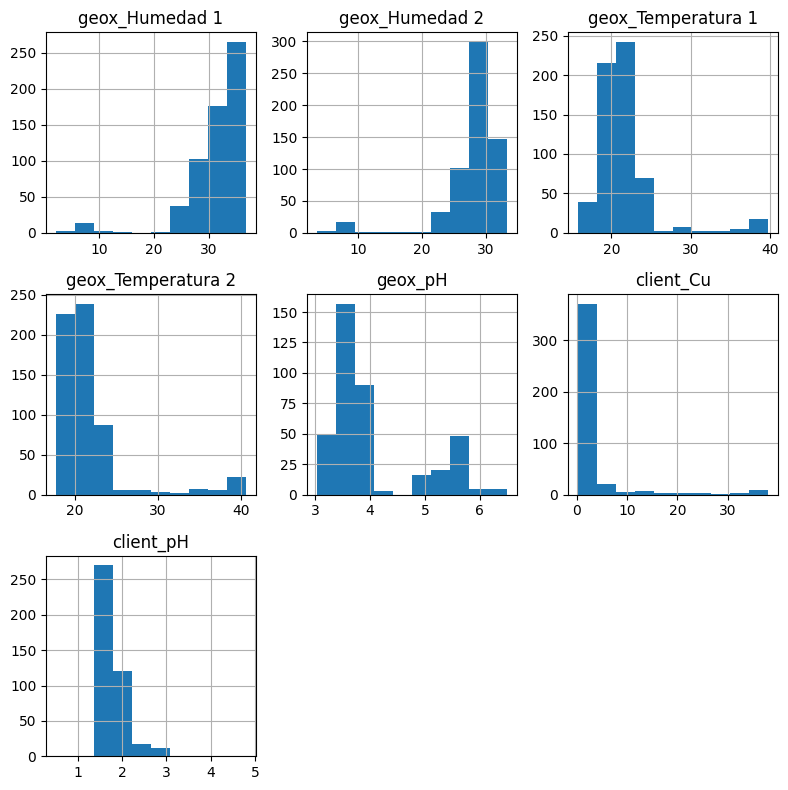

In [29]:
df_column_mean.hist(figsize=(8, 8))

plt.tight_layout()
plt.show()

#### Correlaciones

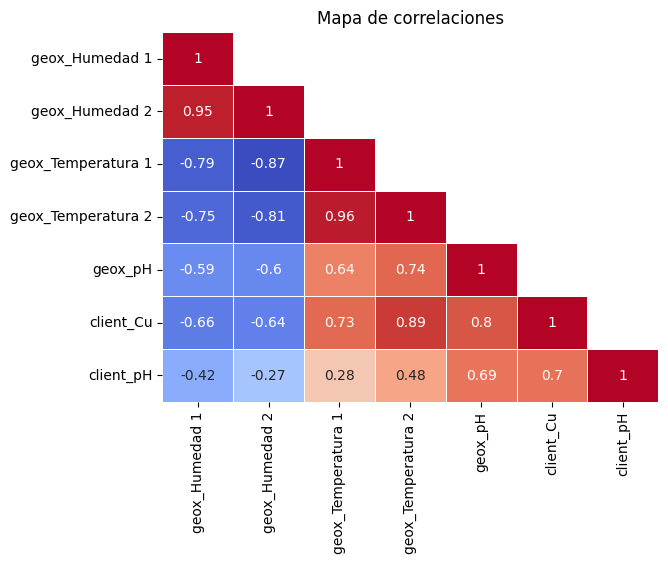

In [30]:
corr_matrix = df_column_mean.corr().round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(corr_matrix,
            annot=True,
            cmap="coolwarm",
            mask=mask,
            linewidths=0.5,
            cbar=False)

plt.title("Mapa de correlaciones")
plt.show()

#### Outliers

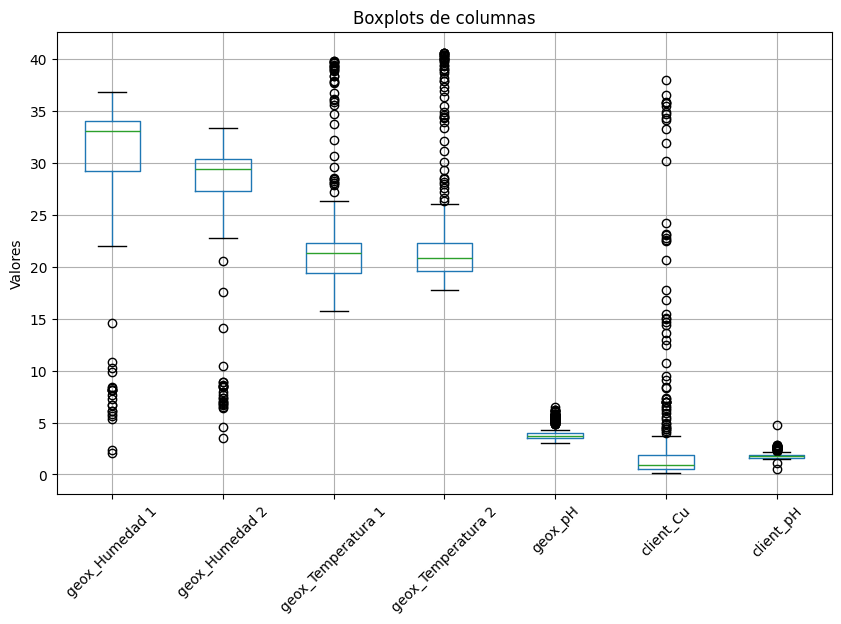

In [31]:
df_column_mean.boxplot(figsize=(10, 6))

plt.title("Boxplots de columnas")
plt.ylabel("Valores")

plt.xticks(rotation=45)
plt.show()

### Gráfico de líneas: Evolución de variables pre-procesadas
* En el siguiente gráfico se presenta la evolución de las variables clave del proceso de lixiviación, monitoreadas a través de sensores instalados en las pilas y los análisis del líquido concentrado final. 
* Se incluyen mediciones de humedad, temperatura y pH capturadas directamente en las pilas de lixiviación (variables con prefijo geox_), así como las concentraciones de cobre (Cu) y pH en el líquido concentrado (variables con prefijo client_). 
* Estas variables son fundamentales para evaluar la eficiencia del proceso de lixiviación y comprender cómo las condiciones internas de las pilas afectan la disolución del mineral y su posterior recuperación en el concentrado.

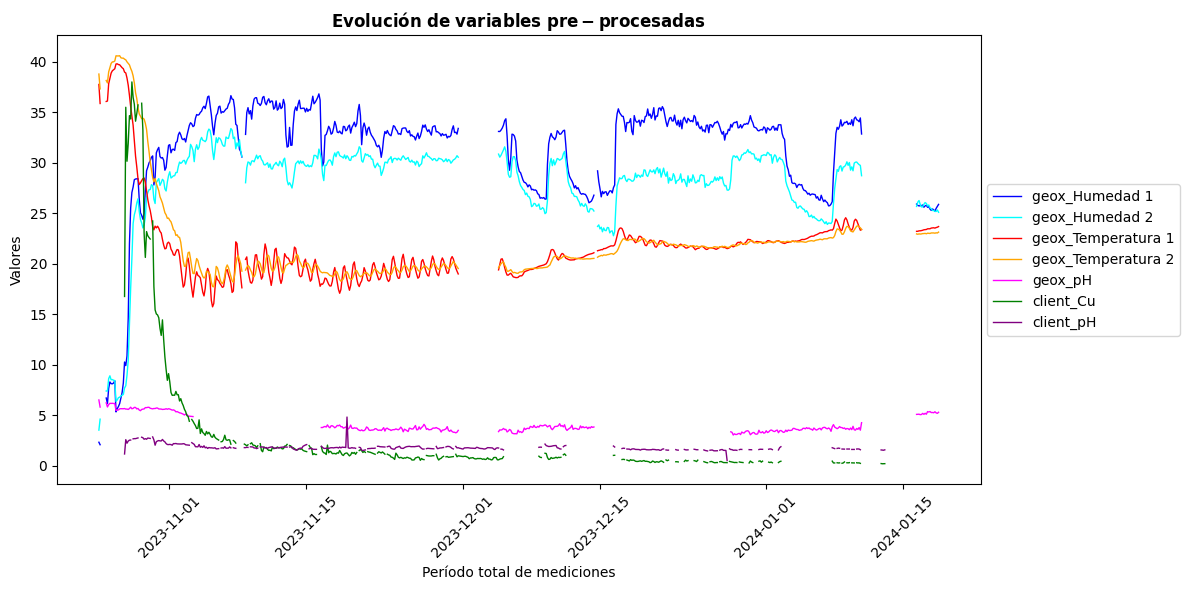

In [108]:
fig, ax = plt.subplots(figsize=(12, 6))

columns = ["geox_Humedad 1", "geox_Humedad 2",
           "geox_Temperatura 1", "geox_Temperatura 2",
           "geox_pH", "client_Cu", "client_pH"]

colors = {
    "geox_Humedad 1": "blue",
    "geox_Humedad 2": "cyan",
    "geox_Temperatura 1": "red",
    "geox_Temperatura 2": "orange",
    "geox_pH": "magenta",
    "client_Cu": "green",
    "client_pH": "purple"
}

for column in columns:
    ax.plot(df_column_mean.index.categories.left, 
            df_column_mean[column], 
            label=column, 
            color=colors[column], 
            linewidth=1)

ax.set_title(r'$\bf{Evolución\ de\ variables\ pre-procesadas}$')
ax.set_xlabel("Período total de mediciones")
ax.set_ylabel("Valores")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Descarga de DataFrame sin preparación de datos

In [33]:
df_column_mean.to_csv("../data/interim/pre_prepariation_assembled_data.csv")

---

# Data Preparation

In [34]:
df_mean_prep = df_column_mean.copy()

## Limpieza de datos

### Verificación y eliminación de filas enteramente NaN

In [35]:
num_rows_with_nan = df_mean_prep.isnull().all(axis=1).sum()

print(f"Cantidad de filas enteramente NaN: {num_rows_with_nan}")

Cantidad de filas enteramente NaN: 47


In [36]:
df_mean_prep = df_mean_prep.dropna(how="all")

In [37]:
print(f"Cantidad de filas: {df_mean_prep.shape[0]}")
print(f"Cantidad de columnas: {df_mean_prep.shape[1]}")

Cantidad de filas: 641
Cantidad de columnas: 7


In [38]:
print(df_mean_prep.isnull().sum())

geox_Humedad 1         37
geox_Humedad 2         37
geox_Temperatura 1     37
geox_Temperatura 2     37
geox_pH               247
client_Cu             215
client_pH             220
dtype: int64


### Tratamiento de outliers

#### Identificación de outliers

In [39]:
def identify_outliers(df):
    lower_bounds = {}
    upper_bounds = {}
    outliers= {}

    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            lower_bounds[column] = lower_bound
            upper_bounds[column] = upper_bound

            # Identificación de outliers
            outliers[column] = df[(df[column] < lower_bound) | 
                                  (df[column] > upper_bound)]
            
    return lower_bounds, upper_bounds, outliers

In [40]:
lower_bounds_1, upper_bounds_1, outliers_1 = identify_outliers(df_mean_prep)

print("Lower bounds:\n", lower_bounds_1)
print("Upper bounds:\n", upper_bounds_1)
print("Outliers:\n",
      {k: v.shape[0] for k, v in outliers_1.items()})

Lower bounds:
 {'geox_Humedad 1': np.float64(21.851514608081235), 'geox_Humedad 2': np.float64(22.6119723170412), 'geox_Temperatura 1': np.float64(15.049206252340776), 'geox_Temperatura 2': np.float64(15.518369083273921), 'geox_pH': np.float64(2.7492553709997694), 'client_Cu': np.float64(-1.46), 'client_pH': np.float64(1.2849999999999997)}
Upper bounds:
 {'geox_Humedad 1': np.float64(41.390866577617004), 'geox_Humedad 2': np.float64(35.069355787776466), 'geox_Temperatura 1': np.float64(26.59449397539428), 'geox_Temperatura 2': np.float64(26.277775209686677), 'geox_pH': np.float64(4.8157644880806245), 'client_Cu': np.float64(3.8200000000000003), 'client_pH': np.float64(2.2050000000000005)}
Outliers:
 {'geox_Humedad 1': 21, 'geox_Humedad 2': 24, 'geox_Temperatura 1': 36, 'geox_Temperatura 2': 48, 'geox_pH': 94, 'client_Cu': 56, 'client_pH': 32}


#### Aplicación de Winsorizing
Se utiliza esta técnica para reemplazar los outliers con el valor más cercano dentro de un rango aceptable, definido por percentiles. Se utiliza los percentiles 25 y 75, como límite inferior y superior, respectivamente. 

Esto ayuda a reducir el impacto de los valores extremos, sin tener que perder datos.

##### Primera aplicación (después del primer tratamiento de outliers y antes de la imputación)
Esta primera aplicación permite eliminar los valores extremos antes de que el proceso de imputación pueda verse afectado por ellos. Al hacer esto, se asegura que la imputación no esté influenciada por outliers que podrían sesgar los resultados.

##### Segunda aplicación (después de la imputación)
Después de la imputación, es posible que aparezcan nuevos outliers, especialmente si los modelos utilizados para la imputación no manejan adecuadamente la variabilidad de los datos. Aplicar Winsorizing nuevamente garantiza que cualquier valor extremo creado durante la imputación sea ajustado.

In [41]:
def winsorize(df, lower_bounds, upper_bounds):
    df_winsorized = df.copy()

    for column in df_winsorized.columns:
        if pd.api.types.is_numeric_dtype(df_winsorized[column]):
            lower_bound = lower_bounds[column]
            upper_bound = upper_bounds[column]

            df_winsorized[column] = np.clip(df_winsorized[column], lower_bound, upper_bound)

    return df_winsorized

#### Primer Winsorizing

In [42]:
df_cleaned = winsorize(df_mean_prep, lower_bounds_1, upper_bounds_1)

df_cleaned.head()

,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,geox_pH,client_Cu,client_pH
"(2023-10-24 19:00:00, 2023-10-24 22:00:00]",21.851515,22.611972,26.594494,26.277775,4.815764,NaN,NaN
"(2023-10-24 22:00:00, 2023-10-25 01:00:00]",21.851515,22.611972,26.594494,26.277775,4.815764,NaN,NaN
"(2023-10-25 13:00:00, 2023-10-25 16:00:00]",21.851515,22.611972,26.594494,26.277775,4.815764,NaN,NaN
"(2023-10-25 16:00:00, 2023-10-25 19:00:00]",21.851515,22.611972,26.594494,26.277775,4.815764,NaN,NaN
"(2023-10-25 19:00:00, 2023-10-25 22:00:00]",21.851515,22.611972,26.594494,26.277775,4.815764,NaN,NaN


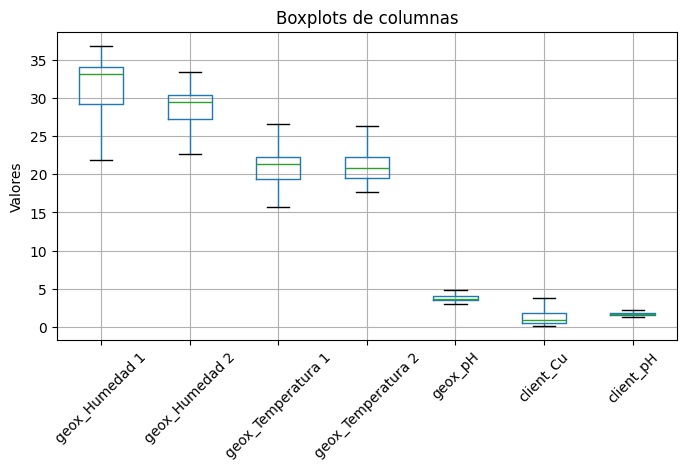

In [43]:
df_cleaned.boxplot(figsize=(8, 4))

plt.title("Boxplots de columnas")
plt.ylabel("Valores")

plt.xticks(rotation=45)
plt.show()

---

### Imputación de datos

#### MICE (Multiple Imputation by Chained Equations)
Se utiliza este método iterativo debido a la colinealidad entre algunas columnas del conjunto de datos, y porque los nulos se presentan en patrones al interior de cada subconjunto (Geo-X y cliente)

##### Estandarización de datos para eficiencia en el uso de BayesianRidge como estimador de MICE
En este contexto, la estandarización ayuda a garantizar que las relaciones lineales entre las características sean coherentes y comparables, lo cual es muy útil cuando las características tienen escalas diferentes (grados de temperatura, porcentaje de humedad, nivel de pH y cantidad de gramos de Cu por litro). De este modo, se asegura que cada característica contribuya de manera equitativa al ajuste del modelo de regresión bayesiana, evitando que las variables con escalas mayores dominen las predicciones.

In [44]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned),
                         columns=df_mean_prep.columns)

df_scaled.head()

,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,geox_pH,client_Cu,client_pH
0,-2.745242,-2.377108,2.433535,2.421901,1.667949,NaN,NaN
1,-2.745242,-2.377108,2.433535,2.421901,1.667949,NaN,NaN
2,-2.745242,-2.377108,2.433535,2.421901,1.667949,NaN,NaN
3,-2.745242,-2.377108,2.433535,2.421901,1.667949,NaN,NaN
4,-2.745242,-2.377108,2.433535,2.421901,1.667949,NaN,NaN


##### Imputación de datos

Se utiliza BayesianRidge como el modelo para imputar los valores faltantes, porque es óptimo para problemas donde la predicción de un valor depende de relaciones lineales entre las características. Este enfoque es especialmente útil cuando existe una dependencia global entre las variables, permitiendo que el modelo ajuste una regresión bayesiana que regulariza los coeficientes y evita el sobreajuste.

En este caso, aunque las filas del dataset están ordenadas sucesivamente en intervalos de horas, lo que podría sugerir dependencia temporal, el modelo captura mejor las relaciones generales entre las características a lo largo del tiempo.

Además, BayesianRidge ofrece un rendimiento computacional eficiente, incluso con conjuntos de datos más grandes, asegurando una convergencia rápida y precisa.

In [45]:
knn_imputer = IterativeImputer(estimator=BayesianRidge(),
                           max_iter=50, 
                           random_state=42)

# Imputación sin escalado
df_imputed_no_scaled = pd.DataFrame(knn_imputer.fit_transform(df_cleaned),
                          columns=df_scaled.columns)

# Imputación con escalado y desescalado
df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_scaled),
                          columns=df_scaled.columns)

df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed),
                          columns=df_imputed.columns)          

In [46]:
print(df_imputed.isnull().sum())

geox_Humedad 1        0
geox_Humedad 2        0
geox_Temperatura 1    0
geox_Temperatura 2    0
geox_pH               0
client_Cu             0
client_pH             0
dtype: int64


##### Datos escalados vs Datos no escalados
Después de obtener los resultados con y sin escalado de datos previo a la imputación, se llegaron a las siguientes conclusiones:
* En ambos casos, los estadísticos descriptivos del DataFrame post-imputación son similares, al igual que los gráficos de distribución.
* El modelo de imputación sin escalado alcanzó la convergencia en 29 iteraciones, mientras que el modelo con escalado necesitó 47 iteraciones para converger.
* Sin embargo, el escalado tiene un impacto positivo en modelos como el Regresor de Árbol de Decisión y el Chain Regressor, mejorando tanto la precisión (disminución del MSE) como la capacidad explicativa (aumento del R²).
* En cambio, para modelos como la Regresión Lineal y la Potenciación por Gradientes, el escalado no parece ser crucial, ya que los resultados son casi equivalentes con y sin escalado.

#### Segundo Winsorizing

**IMPORTANTE** 
**Siguiente celda**
* Si se opta por trabajar con los datos que fueron escalados durante el proceso de imputación, utilizar la variable df_imputed
* En caso contrario, utilizar la variable df_imputed_no_scaled

In [47]:
lower_bounds_2, upper_bounds_2, outliers_2 = identify_outliers(df_imputed)

df_imputed_cleaned = winsorize(df_imputed, lower_bounds_2, upper_bounds_2)

print("Lower bounds:\n", lower_bounds_2)
print("Upper bounds:\n", upper_bounds_2)
print("Outliers:\n",
      {k: v.shape[0] for k, v in outliers_2.items()})

Lower bounds:
 {'geox_Humedad 1': np.float64(23.161144457783124), 'geox_Humedad 2': np.float64(23.227728390391505), 'geox_Temperatura 1': np.float64(15.279222116250253), 'geox_Temperatura 2': np.float64(15.679807363292356), 'geox_pH': np.float64(2.781138152058486), 'client_Cu': np.float64(-1.2249999999999999), 'client_pH': np.float64(1.3154500179722932)}
Upper bounds:
 {'geox_Humedad 1': np.float64(40.55455515539548), 'geox_Humedad 2': np.float64(34.63613895719061), 'geox_Temperatura 1': np.float64(26.392079883054492), 'geox_Temperatura 2': np.float64(26.133379763548092), 'geox_pH': np.float64(4.77713593791714), 'client_Cu': np.float64(3.535), 'client_pH': np.float64(2.209180176020121)}
Outliers:
 {'geox_Humedad 1': 22, 'geox_Humedad 2': 28, 'geox_Temperatura 1': 36, 'geox_Temperatura 2': 48, 'geox_pH': 95, 'client_Cu': 66, 'client_pH': 19}


#### Comparación de estadísticos pre y post imputación

In [48]:
print("Pre-imputación:")
df_cleaned.describe().round(2)

Pre-imputación:


,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,geox_pH,client_Cu,client_pH
count,604.00,604.00,604.00,604.00,394.00,426.00,421.00
mean,31.74,28.59,21.14,21.25,3.90,1.41,1.77
std,3.60,2.52,2.24,2.08,0.55,1.17,0.19
min,21.85,22.61,15.73,17.72,3.03,0.18,1.28
25%,29.18,27.28,19.38,19.55,3.52,0.52,1.63
50%,33.11,29.40,21.35,20.80,3.71,0.95,1.74
75%,34.06,30.40,22.27,22.24,4.04,1.84,1.86
max,36.84,33.40,26.59,26.28,4.82,3.82,2.21


In [49]:
print("Post-imputación:")
df_imputed_cleaned.describe().round(2)

Post-imputación:


,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,geox_pH,client_Cu,client_pH
count,641.00,641.00,641.00,641.00,641.00,641.00,641.00
mean,31.83,28.63,21.11,21.22,3.85,1.35,1.80
std,3.39,2.39,2.15,1.99,0.46,1.10,0.20
min,23.16,23.23,15.73,17.72,3.03,-0.41,1.32
25%,29.68,27.51,19.45,19.60,3.53,0.56,1.65
50%,33.05,29.28,21.08,20.84,3.71,0.95,1.76
75%,34.03,30.36,22.22,22.21,4.03,1.75,1.87
max,36.84,33.40,26.39,26.13,4.78,3.54,2.21


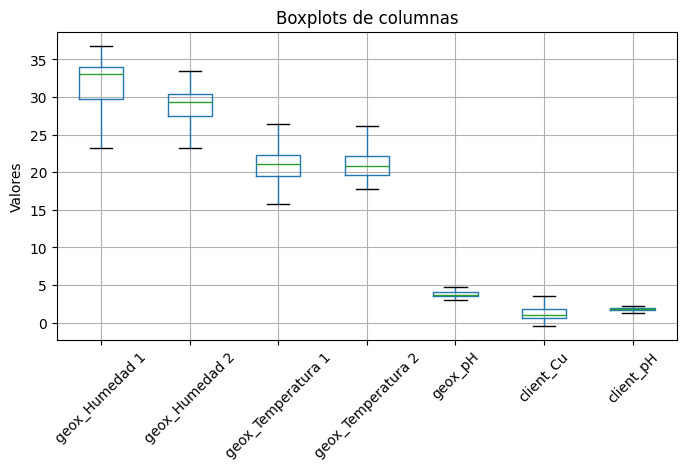

In [50]:
df_imputed_cleaned.boxplot(figsize=(8, 4))

plt.title("Boxplots de columnas")
plt.ylabel("Valores")

plt.xticks(rotation=45)
plt.show()

Los estadísticos de las columnas son similares entre el conjunto de datos previo a la imputación de datos con MICE y la eliminación de filas vacías, y el conjunto posterior. No obstante, la mínima de client_Cu es de -0.41, porque el bigote inferior de su boxplot rebasa el valor de 0.

#### Comprobar valores negativos en client_Cu

In [51]:
negative_count = (df_imputed_cleaned["client_Cu"] < 0).sum()
print(f"Cantidad de valores negativos en client_Cu: {negative_count}")

Cantidad de valores negativos en client_Cu: 9


#### Reemplazar valores negativos por 0
Dado que hay 9 valores negativos en la columna client_Cu de un total de 641, lo que representa una proporción pequeña de los datos (~1.4%), se procede a reemplazarlos por 0.
Las ventajas de esta medida son:
* Este método es simple de implementar y no introduce complejidad adicional en el análisis.
* No se introducen sesgos potenciales derivados de reimputaciones o sustituciones y se mantienen los datos ajustados a la realidad.

In [52]:
df_imputed_cleaned["client_Cu"] = np.where(df_imputed_cleaned["client_Cu"] < 0, 
                                           0, 
                                           df_imputed_cleaned["client_Cu"])

print(df_imputed_cleaned["client_Cu"].describe().round(2))

count    641.00
mean       1.35
std        1.10
min        0.00
25%        0.56
50%        0.95
75%        1.75
max        3.54
Name: client_Cu, dtype: float64


---

### Tratamiento de colinealidad
Antes de proceder con el entrenamiento de los modelos predictivos, es necesario evaluar el nivel de correlación entre las variables `geox_Humedad 1` y `geox_Humedad 2`, por un lado, y entre `geox_Temperatura 1` y `geox_Temperatura 2`, por el otro, para corroborar si existe colinealidad entre éstas.

Esto es fundamental, por las siguientes razones:
* **Impacto en la interpretación del modelo:** El modelo puede tener problemas para determinar el impacto individual de cada una sobre la variable dependiente, ya que ambas pueden estar representando el mismo fenómeno.
* **Problemas en la estimación de los coeficientes:** Los coeficientes de las variables colineales pueden ser imprecisos.
* **Problemas de desempeño del modelo y sobreajuste:** La colinealidad puede generar modelos menos generalizables y, por ende, más susceptibles a sobreajuste. 

#### Correlación entre geox_Humedad 1 y geox_Humedad 2

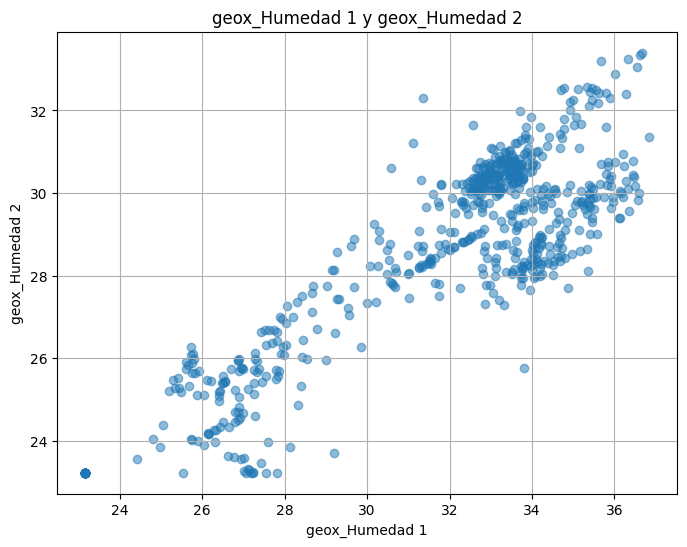

In [53]:
plt.figure(figsize=(8, 6))
plt.scatter(df_imputed_cleaned["geox_Humedad 1"], df_imputed_cleaned["geox_Humedad 2"], alpha=0.5)
plt.title("geox_Humedad 1 y geox_Humedad 2")
plt.xlabel("geox_Humedad 1")
plt.ylabel("geox_Humedad 2")
plt.grid(True)
plt.show()

In [54]:
corr_humedad = df_imputed_cleaned[["geox_Humedad 1", "geox_Humedad 2"]].corr()
corr_humedad

,geox_Humedad 1,geox_Humedad 2
geox_Humedad 1,1.000000,0.875894
geox_Humedad 2,0.875894,1.000000


#### Correlación entre geox_Temperatura 1 y geox_Temperatura 2

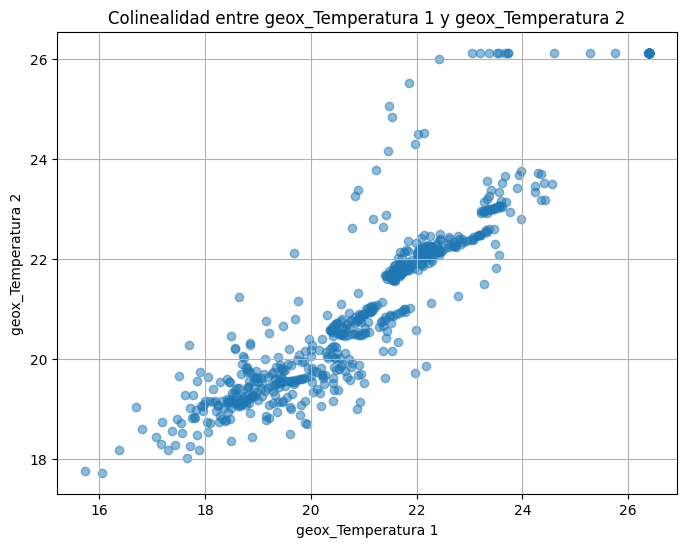

In [55]:
plt.figure(figsize=(8, 6))
plt.scatter(df_imputed_cleaned["geox_Temperatura 1"], df_imputed_cleaned["geox_Temperatura 2"], alpha=0.5)
plt.title("Colinealidad entre geox_Temperatura 1 y geox_Temperatura 2")
plt.xlabel("geox_Temperatura 1")
plt.ylabel("geox_Temperatura 2")
plt.grid(True)
plt.show()

In [56]:
corr_temperatura = df_imputed_cleaned[["geox_Temperatura 1", "geox_Temperatura 2"]].corr()
corr_temperatura

,geox_Temperatura 1,geox_Temperatura 2
geox_Temperatura 1,1.000000,0.924755
geox_Temperatura 2,0.924755,1.000000


**Observaciones**  
Las correlaciones de 0.875 y 0.924 muestran que hay una alta colinealidad entre los sensores de humedad y temperatura. Esto sugiere que hay información redundante en estas variables, lo que puede afectar la estabilidad y generalización de los modelos.  
  
Por consiguiente, se usará la técnica PCA (*Principal Component Analysis*) para manejar la colinealidad. 

#### PCA (Principal Component Analysis)
Se usa esta técnica para tratar la colinealidad entre variables y reducir la dimensionalidad. Esta técnica permite transformar un conjunto de variables correlacionadas en componentes principales. 

`geox_Humedad 1` y `geox_Humedad 2`, así como `geox_Temperatura 1` y `geox_Temperatura 2` están altamente correlacionadas entre sí, lo que puede causar problemas de multicolinealidad en los modelos de regresión.

Al aplicar PCA, se combinan estas variables correlacionadas en un número menor de componentes principales que capturan la mayor parte de la varianza. Esto puede ayudar a evitar el sobreajuste en el entrenamiento de modelos de regresión.

In [57]:
def apply_pca(df, column_groups, n_components=1):
    df_pca = df.copy()
    scaler = StandardScaler()

    for new_column, cols in column_groups.items():
        selected_cols = df_pca[cols]
        scaled_data = scaler.fit_transform(selected_cols)

        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(scaled_data)

        print(f"Componentes principales para {new_column}:")
        for i, component in enumerate(pca.components_):
            print(f"Componente {i+1}: {dict(zip(cols, component))}")

        df_pca[new_column] = pca_result

        pca_result_back = pca.inverse_transform(pca_result)
        df_pca[new_column] = scaler.inverse_transform(pca_result_back)

    return df_pca

In [58]:
column_groups = {
    "geox_Humedad": ["geox_Humedad 1", "geox_Humedad 2"],
    "geox_Temperatura": ["geox_Temperatura 1", "geox_Temperatura 2"]
}

df_pca = apply_pca(df_imputed_cleaned, column_groups)

df_pca = df_pca.drop(columns=["geox_Humedad 1", "geox_Humedad 2",
                              "geox_Temperatura 1", "geox_Temperatura 2"])

new_order = (
    ["geox_Humedad", "geox_Temperatura"] + 
    [col for col in df_pca.columns 
     if col not in ["geox_Humedad", "geox_Temperatura"]]
)

df_pca = df_pca[new_order]

df_pca.head()

Componentes principales para geox_Humedad:
Componente 1: {'geox_Humedad 1': np.float64(0.7071067811865476), 'geox_Humedad 2': np.float64(0.7071067811865475)}
Componentes principales para geox_Temperatura:
Componente 1: {'geox_Temperatura 1': np.float64(0.7071067811865476), 'geox_Temperatura 2': np.float64(0.7071067811865475)}


,geox_Humedad,geox_Temperatura,geox_pH,client_Cu,client_pH
0,23.660703,26.4074,4.777136,3.433616,2.20918
1,23.660703,26.4074,4.777136,3.433616,2.20918
2,23.660703,26.4074,4.777136,3.433616,2.20918
3,23.660703,26.4074,4.777136,3.433616,2.20918
4,23.660703,26.4074,4.777136,3.433616,2.20918


**Observaciones**  
El hecho de que los pesos de ambas características sean exactamente iguales (0.7071) indica que estas características están altamente correlacionadas y que el componente principal está capturando un promedio ponderado de ambas.  
  
Este resultado confirma que la aplicación de PCA está reduciendo la dimensionalidad de manera efectiva, combinando características que están altamente correlacionadas en un solo componente principal.

## Estadísticos de data procesada

### Estadísticos generales

In [59]:
df_pca.describe()

,geox_Humedad,geox_Temperatura,geox_pH,client_Cu,client_pH
count,641.000000,641.000000,641.000000,641.000000,641.000000
mean,31.827080,21.113244,3.849950,1.352988,1.795112
std,3.285380,2.110541,0.464273,1.095816,0.196049
min,23.660703,16.551407,3.028269,0.000000,1.315450
25%,30.131169,19.391803,3.529637,0.560000,1.650599
50%,33.124106,20.888541,3.711067,0.950000,1.760000
75%,34.031126,22.213626,4.028637,1.750000,1.874031
max,37.623608,26.407400,4.777136,3.535000,2.209180


### Gráfico de líneas: Evolución de variables procesadas
* Cabe destacar que la baja cantidad observada en los valores de client_Cu se debe, en gran medida, al truncado realizado para limitar los valores atípicos, garantizando así un análisis más controlado y representativo, a la vez de un entrenamiento más eficiente y de mejor desempeño de los modelos de Machine Learning.

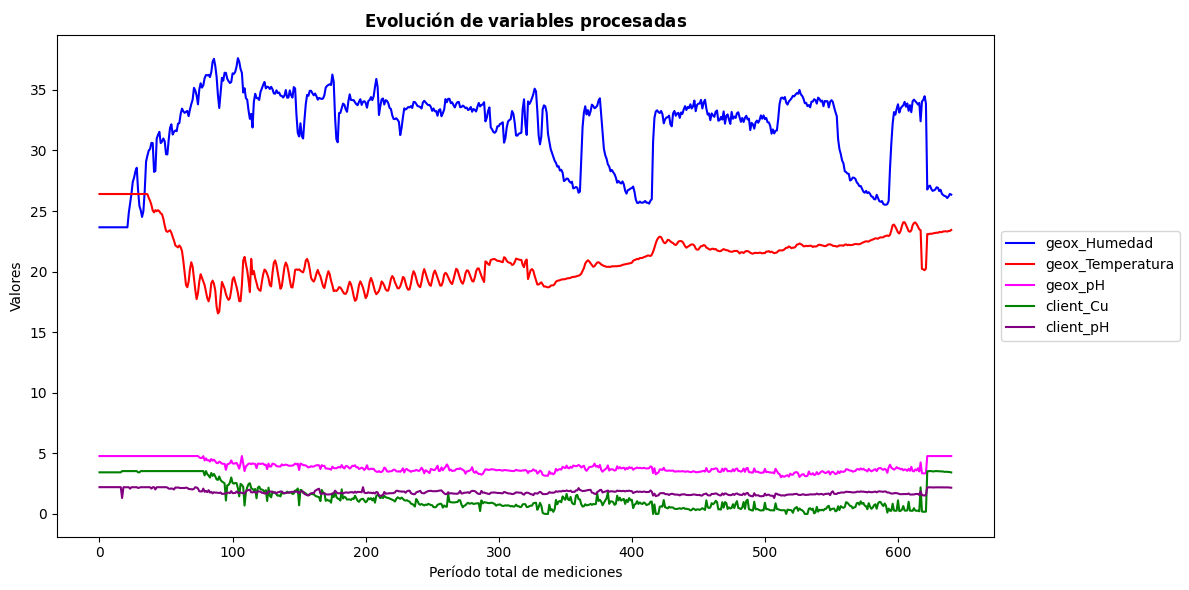

In [106]:
fig, ax = plt.subplots(figsize=(12, 6))

columns = ["geox_Humedad", "geox_Temperatura", 
           "geox_pH", "client_Cu", "client_pH"]

colors = {
    "geox_Humedad": "blue",
    "geox_Temperatura": "red",
    "geox_pH": "magenta",
    "client_Cu": "green",
    "client_pH": "purple"
}

for column in columns:
    ax.plot(df_pca.index, 
            df_pca[column], 
            label=column,
            color=colors[column])

ax.set_title(r"$\bf{Evolución\ de\ variables\ procesadas}$")
ax.set_xlabel("Período total de mediciones")
ax.set_ylabel("Valores")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout() 
plt.show()

**Observaciones**
1. **Relación entre geox_Temperatura y geox_Humedad**  
* **Patrón inverso:** Se puede notar un patrón inverso entre ambas variables. Mientras que la temperatura tiende a disminuir, la humedad parece aumentar. 
* **Estabilidad relativa:** Aunque ambos tienen fluctuaciones, parecen estabilizarse después de un tiempo.
* **Impacto en el proceso:** En el contexto de lixiviaicón, los cambios de temperatura pueden afectar la tasa de reacción química y, por lo tanto, la lixiviación del mineral. A su vez, un aumento de la humedad podría afectar la permeabilidad de las pilas, lo que también influiría en la eficiencia del proceso.  
  
2. **Relación entre geox_pH, client_pH y client_Cu**  
* `geox_pH` y `client_pH`:
    * Ambas variables muestran valores bajos, lo que es característico de un entorno ácido. 
    * A pesar de esto, geox_pH parece ser un poco más variable y tiende a tener valores ligeramente más altos que client_pH. Esto sugiere que, a lo largo del proceso, el pH disminuye un poco más hacia el final. Esto es lo esperado, ya que indica que la lixiviación se ha completado de manera efectiva y que los ácidos utilizados han logrado disolver los minerales.
  
* `client_Cu` y `client_pH`:
    * Hay una correlación negativa entre ambas variables: a medida que el pH es más bajo, la solubilidad del cobre es mayor, lo que resulta en una mayor concentración de Cu en el líquido lixiviado. 

---

### Exportar dataset

In [ ]:
# Exportar datos procesados
# df_pca.to_csv("../dataset/processed/df_pca.csv")

---

# Modeling

### Selección de variables independientes y dependientes

In [62]:
df_model = df_pca.copy()

X = df_model[["geox_Humedad", "geox_Temperatura", "geox_pH"]]
y = df_model[["client_Cu", "client_pH"]]

### Dividir en conjunto de entrenamiento y prueba

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

### Estandarizar datos

In [64]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

---

## 1. Linear Regression

### Mejores hiperparámetros

In [65]:
linear_params = {
    "fit_intercept": [True, False],
    "copy_X": [True, False]
}

linear_reg = LinearRegression()
linear_search = GridSearchCV(linear_reg, 
                             linear_params, 
                             cv=5, 
                             scoring="neg_mean_squared_error")

linear_search.fit(X_train_scaled, y_train_scaled)

print("Mejores parámetros:", linear_search.best_params_)

Mejores parámetros: {'copy_X': True, 'fit_intercept': False}


#### Hiperparámetros
`copy_X`: True
* Durante el ajuste del modelo, se hace una copia de los datos de entrada en lugar de modificarlos directamente.

`fit_intercept`: False
* El modelo no ajustará un intercepto adicional o constante en la función de regresión. Esto indica que la línea de regresión pase por el origen (0,0).

### Entrenamiento

In [66]:
best_linear_reg = linear_search.best_estimator_
model_reg = MultiOutputRegressor(best_linear_reg)
model_reg.fit(X_train_scaled, y_train_scaled)

MultiOutputRegressor(estimator=LinearRegression(fit_intercept=False))

### Predicciones

In [67]:
reg_predictions_scaled = model_reg.predict(X_test_scaled)
reg_predictions = scaler_y.inverse_transform(reg_predictions_scaled)

### Evaluación

In [68]:
def evaluate_model(y_test, 
                   model_predictions):
    mae = mean_absolute_error(y_test, model_predictions)
    mse = mean_squared_error(y_test, model_predictions)
    r2 = r2_score(y_test, model_predictions)

    print("Mean Absolute Error (promedio):", mae)
    print("Mean Squared Error (promedio):", mse)
    print("R^2 Score (promedio):", r2)

    return mae, mse, r2

In [69]:
def evaluate_model_sep(y_test, 
                       model_predictions):
    mae_list = mean_absolute_error(y_test, 
                                   model_predictions, 
                                   multioutput="raw_values")
    mse_list = mean_squared_error(y_test, 
                                  model_predictions, 
                                  multioutput="raw_values")
    r2_list = r2_score(y_test, 
                       model_predictions, 
                       multioutput="raw_values")

    print("\nMean Absolute Error (Cu):", mae_list[0])
    print("Mean Squared Error (Cu):", mse_list[0])
    print("R^2 Score (Cu):", r2_list[0])

    print("\nMean Absolute Error (pH):", mae_list[1])
    print("Mean Squared Error (pH):", mse_list[1])
    print("R^2 Score (pH):", r2_list[1])

    return mae_list, mse_list, r2_list

In [70]:
mae_linear_mean, mse_linear_mean, r2_linear_mean = (
    evaluate_model(y_test, reg_predictions)
)
mae_linear_sep, mse_linear_sep, r2_linear_sep = (
    evaluate_model_sep(y_test, reg_predictions)
)

Mean Absolute Error (promedio): 0.16809658690296092
Mean Squared Error (promedio): 0.07972553666954793
R^2 Score (promedio): 0.8352525999200744

Mean Absolute Error (Cu): 0.25741844435253713
Mean Squared Error (Cu): 0.14946474131633444
R^2 Score (Cu): 0.8978686041179235

Mean Absolute Error (pH): 0.07877472945338469
Mean Squared Error (pH): 0.00998633202276142
R^2 Score (pH): 0.7726365957222252


### Validación cruzada

In [71]:
def evaluate_cross_val(X_train, y_train, model, cv=10):
    reg_cross_predictions = cross_val_predict(model, 
                                              X_train, 
                                              y_train, 
                                              cv=cv)
    
    mae_scores = mean_absolute_error(y_train, 
                                     reg_cross_predictions)
    mse_scores = mean_squared_error(y_train, 
                                    reg_cross_predictions)
    r2_scores = r2_score(y_train, 
                         reg_cross_predictions)
    
    print("MAE promedio en validación cruzada (promedio):", mae_scores)
    print("MSE promedio en validación cruzada (promedio):", mse_scores)
    print("R^2 promedio en validación cruzada (promedio):", r2_scores)
    
    return mae_scores, mse_scores, r2_scores

In [72]:
def evaluate_cross_val_sep(X_train, y_train, model, cv=10):
    reg_cross_predictions = cross_val_predict(model, 
                                              X_train, 
                                              y_train, 
                                              cv=cv)
    
    # Calcular las métricas por separado para cada variable
    mae_sep = mean_absolute_error(y_train, 
                                  reg_cross_predictions, 
                                  multioutput="raw_values")
    mse_sep = mean_squared_error(y_train, 
                                 reg_cross_predictions, 
                                 multioutput="raw_values")
    r2_sep = r2_score(y_train, 
                      reg_cross_predictions, 
                      multioutput="raw_values")
    
    print("\nMAE promedio en validación cruzada (Cu):", mae_sep[0])
    print("MSE promedio en validación cruzada (Cu):", mse_sep[0]) 
    print("R^2 promedio en validación cruzada (Cu):", r2_sep[0])   
    print("\nMAE promedio en validación cruzada (pH):", mae_sep[1])
    print("MSE promedio en validación cruzada (pH):", mse_sep[1])
    print("R^2 promedio en validación cruzada (pH):", r2_sep[1])
    
    return mae_sep, mse_sep, r2_sep

In [73]:
mae_linear_scores, mse_linear_scores, r2_linear_scores = (
    evaluate_cross_val(X_train_scaled, y_train_scaled, best_linear_reg)
)
mae_linear_scores_sep, mse_linear_scores_sep, r2_linear_scores_sep = (
    evaluate_cross_val_sep(X_train_scaled, y_train_scaled, best_linear_reg)
)

MAE promedio en validación cruzada (promedio): 0.26926283312184585
MSE promedio en validación cruzada (promedio): 0.16604559391226523
R^2 promedio en validación cruzada (promedio): 0.8339544060877349

MAE promedio en validación cruzada (Cu): 0.18758708629229123
MSE promedio en validación cruzada (Cu): 0.07400522600469955
R^2 promedio en validación cruzada (Cu): 0.9259947739953005

MAE promedio en validación cruzada (pH): 0.35093857995140043
MSE promedio en validación cruzada (pH): 0.2580859618198309
R^2 promedio en validación cruzada (pH): 0.7419140381801691


---

## 2. Elastic Net

### Mejores hiperparámetros y entrenamiento

In [74]:
elastic_net = ElasticNet()

elasticnet_params = {
    "alpha": np.logspace(-4, 4, 50),
    "l1_ratio": np.linspace(0, 1, 50),  
    "fit_intercept": [True, False]
}

random_search_elasticnet = GridSearchCV(elastic_net, 
                                        elasticnet_params, 
                                        cv=5, 
                                        scoring="neg_mean_squared_error", 
                                        n_jobs=-1)

random_search_elasticnet.fit(X_train_scaled, y_train_scaled)
best_elastic_net = random_search_elasticnet.best_estimator_

print(f"Mejores hiperparámetros con ElasticNet: {random_search_elasticnet.best_params_}")

Mejores hiperparámetros con ElasticNet: {'alpha': np.float64(0.0020235896477251557), 'fit_intercept': False, 'l1_ratio': np.float64(0.02040816326530612)}


#### Hiperparámetros
`alpha`: 0.002023
* Regularización que controla la cantidad total de penalización aplicada al modelo. En este caso, se está aplicando una regularización suave. Esto sugiere que el modelo permite un cierto nivel de complejidad, pero aún busca mantener los coeficientes bajo control.

`l1_ratio` = 0.0204
* Mezcla de las penalizaciones L1 y L2 en el modelo Elastic Net. El modelo está muy sesgado hacia la regularización L2 (Ridge), con solo un 2.04% de la penalización proveniente de L1 (Lasso). Esto sugiere que el modelo no se enfoca en la selección de características como lo haría Lasso, pero aún se beneficia de la regularización L2 para manejar la colinealidad y mejorar la estabilidad.

`fit_intercept`: False
* El modelo no ajustará un intercepto adicional o constante en la función de regresión. Esto indica que la línea de regresión pase por el origen (0,0).

### Predicciones

In [75]:
elastic_predictions_scaled = best_elastic_net.predict(X_test_scaled)
elastic_predictions = scaler_y.inverse_transform(elastic_predictions_scaled)

### Evaluación

In [76]:
mae_elastic_mean, mse_elastic_mean, r2_elastic_mean = (
    evaluate_model(y_test, elastic_predictions)
)
mae_elastic_sep, mse_elastic_sep, r2_elastic_sep = (
    evaluate_model_sep(y_test, elastic_predictions)
)

Mean Absolute Error (promedio): 0.16836687756497565
Mean Squared Error (promedio): 0.07971003182357612
R^2 Score (promedio): 0.8352088248922174

Mean Absolute Error (Cu): 0.25788276785366393
Mean Squared Error (Cu): 0.14942880775599443
R^2 Score (Cu): 0.8978931580337448

Mean Absolute Error (pH): 0.07885098727628734
Mean Squared Error (pH): 0.009991255891157813
R^2 Score (pH): 0.77252449175069


### Validación cruzada

In [77]:
mae_elastic_scores, mse_elastic_scores, r2_elastic_scores = (
    evaluate_cross_val(X_train_scaled, y_train_scaled, best_elastic_net)
)
mae_elastic_scores_sep, mse_elastic_scores_sep, r2_elastic_scores_sep = (
    evaluate_cross_val_sep(X_train_scaled, y_train_scaled, best_elastic_net)
)

MAE promedio en validación cruzada (promedio): 0.2695362841832109
MSE promedio en validación cruzada (promedio): 0.16604110154533863
R^2 promedio en validación cruzada (promedio): 0.8339588984546613

MAE promedio en validación cruzada (Cu): 0.18799238340690774
MSE promedio en validación cruzada (Cu): 0.07400908990808754
R^2 promedio en validación cruzada (Cu): 0.9259909100919125

MAE promedio en validación cruzada (pH): 0.35108018495951404
MSE promedio en validación cruzada (pH): 0.25807311318258974
R^2 promedio en validación cruzada (pH): 0.7419268868174103


---

## 3. Decision Tree Regressor

### Mejores hiperparámetros y pre-entrenamiento

#### Elección de RandomizedSearchCV y RepeatedKFold

Se optó por `RandomizedSearchCV` en lugar de GridSearchCV por varias razones:
1. **Eficiencia computacional**: RandomizedSearchCV evalúa un número fijo de combinaciones aleatorias de hiperparámetros, lo que reduce el tiempo de cómputo en comparación con la búsqueda exhaustiva de GridSearchCV.

2. **Exploración del espacio de hiperparámetros**: La aleatoriedad permite una mejor exploración del espacio de hiperparámetros, lo que puede llevar a identificar configuraciones óptimas que no se encontrarían en una búsqueda exhaustiva.

3. **Flexibilidad**: Se puede ajustar fácilmente el número de iteraciones (n_iter), equilibrando la búsqueda y el tiempo de computación.  

---

Para la validación cruzada, se eligió `RepeatedKFold` porque:
1. **Estimación robusta**: Realiza múltiples repeticiones de la validación cruzada, proporcionando una estimación más confiable del rendimiento del modelo.  
2. **Reducción de variabilidad**: Ayuda a mitigar el efecto de la aleatoriedad en la selección de particiones de entrenamiento y prueba.

In [78]:
tree_regressor = DecisionTreeRegressor(random_state=42)
multi_output_tree_regressor = MultiOutputRegressor(tree_regressor)

tree_params = {
    "estimator__criterion": ["squared_error", "absolute_error"],  
    "estimator__max_depth": [None] + list(range(1, 21)),  
    "estimator__max_features": [None] + np.linspace(0.1, 1.0, 10).tolist() + list(range(1, 11)), 
    "estimator__min_samples_leaf": list(range(1, 11)),  
    "estimator__min_samples_split": list(range(2, 11)),  
    "estimator__splitter": ["best", "random"]  
}

tree_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

tree_search = RandomizedSearchCV(multi_output_tree_regressor, 
                                 param_distributions=tree_params, 
                                 n_iter=100, 
                                 cv=tree_cv, 
                                 scoring="neg_mean_squared_error", 
                                 n_jobs=-1,
                                 random_state=42) 
    

tree_search.fit(X_train, y_train)
    
best_tree_regressor = tree_search.best_estimator_

print("Mejores hiperparámetros:", tree_search.best_params_)

Mejores hiperparámetros: {'estimator__splitter': 'best', 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 7, 'estimator__max_features': None, 'estimator__max_depth': 18, 'estimator__criterion': 'squared_error'}


#### Hiperparámetros
`criterion`: "squared_error"
* Utiliza el error cuadrático como criterio para dividir los nodos. Este criterio es sensible a los outliers, lo que puede ser beneficioso si se desea maximizar la precisión en la predicción.

`max_depth`: 18
* Limita la profundidad máxima del árbol a 18 niveles, lo que ayuda a conseguir un equilibrio entre la prevención del sobreajuste y un mayor aprendizaje de las relaciones en los datos.

`max_features`: None
* Utiliza todas las características disponibles para cada división de nodo. Esto puede permitir que el modelo aproveche al máximo la información en los datos, aunque podría aumentar el riesgo de sobreajuste.

`min_samples_leaf`: 7
* El número mínimo de muestras necesarias en una hoja del árbol es de 7. Esto asegura que las hojas no sean demasiado pequeñas, lo que puede ayudar a reducir el sobreajuste.

`min_samples_split`: 2
* El número mínimo de muestras requeridas para dividir un nodo es de al menos 2, permitiendo que se realicen más divisiones y potencialmente mejorando el ajuste del modelo a los datos.

`splitter`: "best"
* Selecciona la mejor división en cada nodo en lugar de una división aleatoria, lo que optimiza la precisión de cada partición del árbol.

### Entrenamiento

In [79]:
best_tree_regressor.fit(X_train, y_train)

MultiOutputRegressor(estimator=DecisionTreeRegressor(max_depth=18,
                                                     min_samples_leaf=7,
                                                     random_state=42))

### Predicciones

In [80]:
tree_predictions = best_tree_regressor.predict(X_test)

### Evaluación

In [81]:
mae_tree_mean, mse_tree_mean, r2_tree_mean = (
    evaluate_model(y_test, tree_predictions)
)
mae_tree_sep, mse_tree_sep, r2_tree_sep = (
    evaluate_model_sep(y_test, tree_predictions)
)

Mean Absolute Error (promedio): 0.12144909071097076
Mean Squared Error (promedio): 0.043772151802514085
R^2 Score (promedio): 0.867915382256777

Mean Absolute Error (Cu): 0.17545500594017324
Mean Squared Error (Cu): 0.07829110571689618
R^2 Score (Cu): 0.9465025674844962

Mean Absolute Error (pH): 0.06744317548176827
Mean Squared Error (pH): 0.009253197888131986
R^2 Score (pH): 0.7893281970290578


### Validación cruzada

In [82]:
mae_tree_scores, mse_tree_scores, r2_tree_scores = (
    evaluate_cross_val(X_train, y_train, best_tree_regressor)
)
mae_tree_scores_sep, mse_tree_scores_sep, r2_tree_scores_sep = (
    evaluate_cross_val_sep(X_train, y_train, best_tree_regressor)
)

MAE promedio en validación cruzada (promedio): 0.10158815174888323
MSE promedio en validación cruzada (promedio): 0.029936663587772055
R^2 promedio en validación cruzada (promedio): 0.8665805634831476

MAE promedio en validación cruzada (Cu): 0.14591433537710108
MSE promedio en validación cruzada (Cu): 0.051706124662181885
R^2 promedio en validación cruzada (Cu): 0.9541527752754537

MAE promedio en validación cruzada (pH): 0.057261968120665384
MSE promedio en validación cruzada (pH): 0.008167202513362226
R^2 promedio en validación cruzada (pH): 0.7790083516908416


---

## 4. Gradient Boosting Regressor

### Mejores hiperparámetros

In [83]:
gbr_params = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 20, 
    "min_samples_split": 9,
    "min_samples_leaf": 5,
    "max_features": 0.75,
    "criterion": "friedman_mse", 
}

#### Hiperparámetros
`n_estimators`: 100
* Número de árboles en el entrenamiento del modelo. Se seleccionó un valor de 100 como un buen equilibrio entre rendimiento y eficiencia.

`learning_rate`: 0.1
* Tasa de aprendizaje, que controla el impacto de cada árbol adicional en la predicción final. Valores más bajos hace que el modelo sea más lento pero c on más precisión al ajustar los datos.

`max_depth`: 20
* La profundidad es un poco mayor que en el Regresor de Árbol de Decisión, porque este modelo se construye secuencialmente y los árboles más profundos ayudan a corregir errores sin comprometer la generalización, gracias al ajuste gradual y controlado.

`criterion`: "friedman_mse"
* Este criterio es específico de los modelos de potenciación por gradientes y mejora la eficiencia del ajuste mediante la minimización del error cuadrático medio.

`min_samples_split`, `min_samples_leaf` y `max_features`: Mismos que en el Regresor de Árbol de Decisión.

#### Búsqueda automática de mejores hiperparámetros
**Comentado por exceso de tiempo de ejecución**

In [84]:
# gbr = GradientBoostingRegressor(random_state=42)
# multi_output_gbr = MultiOutputRegressor(gbr)

# gbr_params = {
#     "estimator__n_estimators": [50, 100, 200, 500],
#     "estimator__learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
#     "estimator__max_depth": [3, 5, 10, 20], 
#     "estimator__min_samples_split": [2, 5, 10, 20],
#     "estimator__min_samples_leaf": [1, 2, 4, 6, 8],
#     "estimator__max_features": [None, "sqrt", "log2", 0.5, 0.75],
#     "estimator__criterion": ["friedman_mse", "squared_error", "absolute_error"]
# }

# gbr_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# gbr_search = RandomizedSearchCV(multi_output_gbr, 
#                                 param_distributions=gbr_params, 
#                                 n_iter=100, 
#                                 cv=gbr_cv, 
#                                 scoring="neg_mean_squared_error", 
#                                 n_jobs=-1,
#                                 random_state=42) 
    

# gbr_search.fit(X_train, y_train)
    
# best_gbr = gbr_search.best_estimator_

# print("Mejores hiperparámetros:", gbr_search.best_params_)

### Entrenamiento

In [85]:
best_gbr = GradientBoostingRegressor(**gbr_params, random_state=5)
model_gbr = MultiOutputRegressor(best_gbr)
model_gbr.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=20,
                                                         max_features=0.75,
                                                         min_samples_leaf=5,
                                                         min_samples_split=9,
                                                         random_state=5))

### Predicciones

In [86]:
gbr_predictions = model_gbr.predict(X_test)

### Evaluación

In [87]:
mae_gbr_mean, mse_gbr_mean, r2_gbr_mean = (
    evaluate_model(y_test, gbr_predictions)
)
mae_gbr_sep, mse_gbr_sep, r2_gbr_sep = (
    evaluate_model_sep(y_test, gbr_predictions)
)

Mean Absolute Error (promedio): 0.11458796364111451
Mean Squared Error (promedio): 0.04191036987856243
R^2 Score (promedio): 0.8807616449751368

Mean Absolute Error (Cu): 0.1668669808285372
Mean Squared Error (Cu): 0.07561572197181436
R^2 Score (Cu): 0.9483306954697254

Mean Absolute Error (pH): 0.06230894645369181
Mean Squared Error (pH): 0.008205017785310487
R^2 Score (pH): 0.8131925944805481


### Validación cruzada

In [88]:
mae_gbr_scores, mse_gbr_scores, r2_gbr_scores = (
    evaluate_cross_val(X_train, y_train, model_gbr)
)
mae_gbr_scores_sep, mse_gbr_scores_sep, r2_gbr_scores_sep = (
    evaluate_cross_val_sep(X_train, y_train, model_gbr)
)

MAE promedio en validación cruzada (promedio): 0.09228593427756278
MSE promedio en validación cruzada (promedio): 0.026668413232578417
R^2 promedio en validación cruzada (promedio): 0.8805222565016029

MAE promedio en validación cruzada (Cu): 0.13349297536761323
MSE promedio en validación cruzada (Cu): 0.04601357043494697
R^2 promedio en validación cruzada (Cu): 0.9592002974910103

MAE promedio en validación cruzada (pH): 0.05107889318751232
MSE promedio en validación cruzada (pH): 0.0073232560302098635
R^2 promedio en validación cruzada (pH): 0.8018442155121953


---

## 5. Regressor Chain

### Entrenamiento

In [89]:
base_regressor = DecisionTreeRegressor(random_state=42)
chain_regressor = RegressorChain(base_regressor, random_state=42)

chain_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

chain_params = {
    "base_estimator__criterion": ["squared_error", "absolute_error"],
    "base_estimator__max_depth": [None] + list(range(1, 21)),
    "base_estimator__max_features": [None] + np.linspace(0.1, 1.0, 10).tolist(),
    "base_estimator__min_samples_leaf": list(range(1, 11)),
    "base_estimator__min_samples_split": list(range(2, 11)),
    "base_estimator__splitter": ["best", "random"]  
}

chain_search = RandomizedSearchCV(chain_regressor,
                                  param_distributions=chain_params,
                                  n_iter=100,
                                  cv=chain_cv,
                                  scoring="neg_mean_squared_error",
                                  n_jobs=-1,
                                  random_state=42)

chain_search.fit(X_train, y_train)

best_chain_regressor = chain_search.best_estimator_

print("Mejores hiperparámetros:", chain_search.best_params_)

Mejores hiperparámetros: {'base_estimator__splitter': 'best', 'base_estimator__min_samples_split': 6, 'base_estimator__min_samples_leaf': 6, 'base_estimator__max_features': 1.0, 'base_estimator__max_depth': 12, 'base_estimator__criterion': 'squared_error'}


#### Hiperparámetros
`criterion`: "squared_error"
* Utiliza el error cuadrático como criterio para dividir los nodos. Este criterio es sensible a los outliers, lo que puede ser beneficioso si se desea maximizar la precisión en la predicción.

`max_depth`: 12
* Limita la profundidad máxima del árbol a 12 niveles. Esto ayuda a controlar la complejidad del modelo, evitando que el árbol se vuelva demasiado profundo y se ajuste en exceso a los datos de entrenamiento, al mismo tiempo que permite capturar relaciones complejas en los datos.

`max_features`: 1.0
* Usa todas las características disponibles (100%) para encontrar la mejor división en cada nodo. Esto le permite al modelo maximizar el uso de la información disponible en los datos, aunque puede incrementar el riesgo de sobreajuste si no se controla bien la profundidad del árbol o el tamaño mínimo de las hojas.

`min_samples_leaf`: 6
* El número mínimo de muestras necesarias en una hoja del árbol es de 6. Esto asegura que las hojas no sean demasiado pequeñas, lo que puede ayudar a reducir el sobreajuste.

`min_samples_split`: 6
* Un nodo debe tener al menos 6 muestras para ser dividido. Esto ayuda a evitar divisiones prematuras, asegurando que los nodos solo se dividan cuando hay suficientes datos, lo que puede ayudar a reducir el riesgo de sobreajuste.

`splitter`: "best"
* Selecciona la mejor división en cada nodo en lugar de una división aleatoria, lo que optimiza la precisión de cada partición del árbol.

### Predicciones

In [90]:
chain_predictions = best_chain_regressor.predict(X_test)

### Evaluación

In [91]:
mae_chain, mse_chain, r2_chain = (
    evaluate_model(y_test, chain_predictions)
)

Mean Absolute Error (promedio): 0.12040540116911796
Mean Squared Error (promedio): 0.044386738478072486
R^2 Score (promedio): 0.8437845297935578


### Validación cruzada

In [92]:
mae_scorer = make_scorer(mean_absolute_error,
                         multioutput="uniform_average") 
mse_scorer = make_scorer(mean_squared_error,
                         multioutput="uniform_average")

In [93]:
kf = KFold(n_splits=10,
           shuffle=True,
           random_state=42)

mae_chain_scores = cross_val_score(best_chain_regressor, 
                                   X_train, 
                                   y_train, 
                                   cv=kf,
                                   scoring=mae_scorer)

mse_chain_scores = cross_val_score(best_chain_regressor, 
                                   X_train, 
                                   y_train, 
                                   cv=kf,
                                   scoring=mse_scorer)

r2_chain_scores = cross_val_score(best_chain_regressor, 
                                  X_train, 
                                  y_train, 
                                  cv=kf,
                                  scoring="r2")

print("MAE promedio en validación cruzada:", mae_chain_scores.mean())
print("MSE promedio en validación cruzada:", mse_chain_scores.mean())
print("R^2 promedio en validación cruzada:", r2_chain_scores.mean())

MAE promedio en validación cruzada: 0.09925467161481726
MSE promedio en validación cruzada: 0.029145096122716013
R^2 promedio en validación cruzada: 0.8491867858578497


---

## 6. XGBoostRegressor

### Mejores hiperparámetros y entrenamiento

In [94]:
xgb_params = {
    "estimator__n_estimators": list(range(100, 501, 50)),
    "estimator__max_depth": list(range(1, 21)),  
    "estimator__learning_rate": np.linspace(0.01, 0.3, 5).tolist(),  
    "estimator__subsample": np.linspace(0.5, 1.0, 5).tolist(),  
    "estimator__colsample_bytree": np.linspace(0.5, 1.0, 5).tolist(),  
    "estimator__gamma": np.linspace(0, 0.5, 5).tolist(),
    "estimator__reg_alpha": np.linspace(0, 1.0, 5).tolist(),  
    "estimator__reg_lambda": np.linspace(0, 1.0, 5).tolist(),  
    "estimator__min_child_weight": list(range(1, 6)),  
}

xgb_regressor = xgb.XGBRegressor(objective="reg:squarederror", 
                                 random_state=42)

multioutput_xgb = MultiOutputRegressor(xgb_regressor)

xgb_search = RandomizedSearchCV(
    estimator=multioutput_xgb,
    param_distributions=xgb_params,
    n_iter=50,
    cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=42),
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train)

best_xgb_model = xgb_search.best_estimator_

print("Mejores hiperparámetros:", xgb_search.best_params_)

Mejores hiperparámetros: {'estimator__subsample': 0.75, 'estimator__reg_lambda': 0.75, 'estimator__reg_alpha': 0.0, 'estimator__n_estimators': 400, 'estimator__min_child_weight': 5, 'estimator__max_depth': 19, 'estimator__learning_rate': 0.01, 'estimator__gamma': 0.125, 'estimator__colsample_bytree': 1.0}


### Hiperparámetros
`subsample`: 0.75
* Se utiliza el 75% de los datos para entrenar cada árbol. Este valor reduce el riesgo de sobreajuste, ya que introduce cierta aleatoriedad en la selección de los datos, mejorando la capacidad de generalización del modelo.  

`reg_lambda`: 0.75
* Este valor controla la regularización L2, que penaliza los coeficientes grandes y ayuda a evitar el sobreajuste. Un valor de 0.75 implica una moderada regularización, lo que mejora la robustez del modelo.  

`reg_alpha`: 0.0
* Este parámetro controla la regularización L1. Un valor de 0 indica que no se aplica regularización L1, permitiendo que todos los coeficientes sean considerados sin penalización.  

`n_estimators`: 400
* Se entrenan 400 árboles. Un número alto de árboles puede mejorar el ajuste del modelo, pero se equilibra con los demás hiperparámetros para evitar el sobreajuste.  

`min_child_weight`: 5
* Controla la cantidad mínima de peso que debe tener un nodo hijo. Un valor de 5 asegura que los nodos hijos no sean demasiado pequeños, lo que ayuda a evitar que el modelo se ajuste en exceso a pequeñas variaciones en los datos.  

`max_depth`: 19
* La profundidad máxima de los árboles es de 19 niveles. Esto permite que el modelo capture relaciones complejas en los datos, aunque se ha limitado para evitar un exceso de complejidad que pueda conducir al sobreajuste.  

`learning_rate`: 0.01
* La tasa de aprendizaje de 0.01 es bastante baja, lo que asegura que cada árbol haga pequeñas correcciones en el modelo, ayudando a evitar que se ajuste en exceso demasiado rápido. Sin embargo, esto también significa que se necesitan más árboles (como los 400 seleccionados) para alcanzar un buen ajuste.  

`gamma`: 0.125
* Este parámetro introduce un umbral de reducción de pérdida en las particiones de nodos. Un valor de 0.125 significa que el árbol solo se dividirá si la reducción de la pérdida es mayor que este valor, lo que ayuda a evitar divisiones innecesarias y mejora la eficiencia.  

`colsample_bytree`: 1.0
* Se selecciona el 100% de las características disponibles para construir cada árbol, lo que permite que el modelo considere toda la información, lo que puede mejorar la capacidad predictiva si no hay riesgo significativo de sobreajuste.  

### Predicciones

In [95]:
xgb_predictions = best_xgb_model.predict(X_test)

### Evaluación

In [96]:
mae_xgb_mean, mse_xgb_mean, r2_xgb_mean = (
    evaluate_model(y_test, xgb_predictions)
)
mae_xgb_sep, mse_xgb_sep, r2_xgb_sep = (
    evaluate_model_sep(y_test, xgb_predictions)
)

Mean Absolute Error (promedio): 0.12306056177159017
Mean Squared Error (promedio): 0.040979471231751455
R^2 Score (promedio): 0.8726294040679932

Mean Absolute Error (Cu): 0.17390719741300686
Mean Squared Error (Cu): 0.07295984283931001
R^2 Score (Cu): 0.9501455

Mean Absolute Error (pH): 0.07221392613017348
Mean Squared Error (pH): 0.008999099624192902
R^2 Score (pH): 0.7951134


### Validación cruzada

In [97]:
mae_xgb_scores, mse_xgb_scores, r2_xgb_scores = (
    evaluate_cross_val(X_train, y_train, best_xgb_model)
)
mae_xgb_scores_sep, mse_xgb_scores_sep, r2_xgb_scores_sep = (
    evaluate_cross_val_sep(X_train, y_train, best_xgb_model)
)

MAE promedio en validación cruzada (promedio): 0.1023726064797139
MSE promedio en validación cruzada (promedio): 0.025052256114174904
R^2 promedio en validación cruzada (promedio): 0.8727391958236694

MAE promedio en validación cruzada (Cu): 0.14197747421553122
MSE promedio en validación cruzada (Cu): 0.042076983364517394
R^2 promedio en validación cruzada (Cu): 0.96269083

MAE promedio en validación cruzada (pH): 0.06276773874389657
MSE promedio en validación cruzada (pH): 0.008027528863832413
R^2 promedio en validación cruzada (pH): 0.78278756


---

# Evaluation

## Medidas de evaluación

 * Mean Absolute Error (MAE):
    * Mide el error promedio absoluto entre las predicciones y los valores reales.
    * A diferencia del MSE, el MAE no eleva al cuadrado los errores, lo que hace que sea menos sensible a grandes desviaciones.
    * Un MAE más bajo indica que, en promedio, las predicciones del modelo están más cerca de los valores reales.

* Mean Squared Error (MSE):
    * Mide la calidad del ajuste del modelo al calcular el promedio de los errores al cuadrado entre los valores predichos y los reales.
    * Un MSE más bajo indica que el modelo está realizando predicciones más cercanas a los valores reales.
    * Penaliza más los errores grandes debido a la naturaleza cuadrática de la métrica.

* R² Score:
    * Mide la proporción de la varianza en las variables dependientes que es explicada por las variables independientes.
    * Un valor de R² más cercano a 1 indica que el modelo está capturando bien la relación entre las variables.
    * Un R² de 0 indica que el modelo no es mejor que predecir la media de los valores.

---

## Cuadro comparativo entre modelos entrenados

### Función para almacenar o actualizar resultados de las evaluaciones

In [98]:
results_df = pd.DataFrame(
    columns=["Modelo", "Variable", "MAE", "MSE", "R^2", "MAE CV", "MSE CV", "R^2 CV"]
)

def add_model_results(model_name, 
                      mae_mean, mse_mean, r2_mean, 
                      mae_sep=None, mse_sep=None, r2_sep=None, 
                      mae_cv_mean=None, mse_cv_mean=None, r2_cv_mean=None, 
                      mae_cv_sep=None, mse_cv_sep=None, r2_cv_sep=None):
    global results_df

    new_results_mean = {
        "Modelo": model_name,
        "Variable": "Promedio",
        "MAE": mae_mean,
        "MSE": mse_mean,
        "R^2": r2_mean,
        "MAE CV": mae_cv_mean if mae_cv_mean is not None else "-",
        "MSE CV": mse_cv_mean if mse_cv_mean is not None else "-",
        "R^2 CV": r2_cv_mean if r2_cv_mean is not None else "-"
    }

    if mae_sep is not None and mse_sep is not None and r2_sep is not None:
        new_results_cu = {
            "Modelo": model_name,
            "Variable": "Cu",
            "MAE": mae_sep[0],
            "MSE": mse_sep[0],
            "R^2": r2_sep[0],
            "MAE CV": mae_cv_sep[0] if mae_cv_sep is not None else "-",
            "MSE CV": mse_cv_sep[0] if mse_cv_sep is not None else "-",
            "R^2 CV": r2_cv_sep[0] if r2_cv_sep is not None else "-"
        }

        new_results_ph = {
            "Modelo": model_name,
            "Variable": "pH",
            "MAE": mae_sep[1],
            "MSE": mse_sep[1],
            "R^2": r2_sep[1],
            "MAE CV": mae_cv_sep[1] if mae_cv_sep is not None else "-",
            "MSE CV": mse_cv_sep[1] if mse_cv_sep is not None else "-",
            "R^2 CV": r2_cv_sep[1] if r2_cv_sep is not None else "-"
        }

        new_results_df = pd.DataFrame([new_results_mean, new_results_cu, new_results_ph])
    else:
        new_results_df = pd.DataFrame([new_results_mean])

    if results_df.empty:
        results_df = new_results_df
    else:
        for i, var in enumerate(["Promedio", "Cu", "pH"] if mae_sep is not None else ["Promedio"]):
            exists = (results_df["Modelo"] == model_name) & (results_df["Variable"] == var)
            if exists.any():
                results_df.loc[exists] = new_results_df.iloc[i].values
            else:
                results_df = pd.concat([results_df, new_results_df.iloc[[i]]], ignore_index=True)

In [99]:
add_model_results("Linear Regression", 
                  mae_linear_mean, mse_linear_mean, r2_linear_mean,
                  mae_linear_sep, mse_linear_sep, r2_linear_sep,
                  mae_linear_scores, mse_linear_scores, r2_linear_scores,
                  mae_linear_scores_sep, mse_linear_scores_sep, r2_linear_scores_sep)

add_model_results("Elastic Net",
                  mae_elastic_mean, mse_elastic_mean, r2_elastic_mean,
                  mae_elastic_sep, mse_elastic_sep, r2_elastic_sep,
                  mae_elastic_scores, mse_elastic_scores, r2_elastic_scores,
                  mae_elastic_scores_sep, mse_elastic_scores_sep, r2_elastic_scores_sep) 
                  
add_model_results("Decision Tree Regressor",
                  mae_tree_mean, mse_tree_mean, r2_tree_mean,
                  mae_tree_sep, mse_tree_sep, r2_tree_sep,
                  mae_tree_scores, mse_tree_scores, r2_tree_scores,
                  mae_tree_scores_sep, mse_tree_scores_sep, r2_tree_scores_sep)
                  
add_model_results("Gradient Boosting Regressor",
                  mae_gbr_mean, mse_gbr_mean, r2_gbr_mean,
                  mae_gbr_sep, mse_gbr_sep, r2_gbr_sep,
                  mae_gbr_scores, mse_gbr_scores, r2_gbr_scores,
                  mae_gbr_scores_sep, mse_gbr_scores_sep, r2_gbr_scores_sep)
                  
add_model_results("Regressor Chain",
                  mae_chain, mse_chain, r2_chain,
                  None, None, None,
                  mae_chain_scores.mean(), mse_chain_scores.mean(), r2_chain_scores.mean())

add_model_results("XGBoost Regressor",
                  mae_xgb_mean, mse_xgb_mean, r2_xgb_mean,
                  mae_xgb_sep, mse_xgb_sep, r2_xgb_sep,
                  mae_xgb_scores, mse_xgb_scores, r2_xgb_scores,
                  mae_xgb_scores_sep, mse_xgb_scores_sep, r2_xgb_scores_sep)

results_df

,Modelo,Variable,MAE,MSE,R^2,MAE CV,MSE CV,R^2 CV
0,Linear Regression,Promedio,0.168097,0.079726,0.835253,0.269263,0.166046,0.833954
1,Linear Regression,Cu,0.257418,0.149465,0.897869,0.187587,0.074005,0.925995
2,Linear Regression,pH,0.078775,0.009986,0.772637,0.350939,0.258086,0.741914
3,Elastic Net,Promedio,0.168367,0.079710,0.835209,0.269536,0.166041,0.833959
4,Elastic Net,Cu,0.257883,0.149429,0.897893,0.187992,0.074009,0.925991
5,Elastic Net,pH,0.078851,0.009991,0.772524,0.351080,0.258073,0.741927
6,Decision Tree Regressor,Promedio,0.121449,0.043772,0.867915,0.101588,0.029937,0.866581
7,Decision Tree Regressor,Cu,0.175455,0.078291,0.946503,0.145914,0.051706,0.954153
8,Decision Tree Regressor,pH,0.067443,0.009253,0.789328,0.057262,0.008167,0.779008
9,Gradient Boosting Regressor,Promedio,0.114588,0.041910,0.880762,0.092286,0.026668,0.880522


## Comparación entre resultados

### 1. Linear Regression
* **Promedio (MAE: 0.1681, MSE: 0.0797, R²: 0.8353):**  
La regresión lineal tiene un desempeño aceptable con un buen ajuste general, explicando alrededor del 83.5% de la variabilidad en las variables dependientes. Sin embargo, el error absoluto y cuadrático promedio no es el más bajo entre los modelos.  
  
* **Cu (MAE: 0.2574, MSE: 0.1495, R²: 0.8979):**  
El modelo ajusta muy bien los valores de Cu, con un R² cercano al 90%, lo que indica que el modelo es bastante efectivo para esta variable. El MAE es relativamente alto, lo que sugiere que las predicciones en Cu tienen errores moderados.  
  
* **pH (MAE: 0.0788, MSE: 0.0100, R²: 0.7726):**  
Para la variable pH, el modelo no es tan efectivo como para Cu. Si bien el error absoluto es bajo, el coeficiente de determinación (R²) muestra que solo el 77.3% de la variabilidad de pH está explicada por el modelo.  
  
* **Validación cruzada (Promedio MAE CV: 0.2693, MSE CV: 0.1660, R² CV: 0.8340):**  
Las métricas en validación cruzada son consistentes con las métricas generales, lo que indica que el modelo es estable y no está sobreajustado.

* **Validación cruzada para Cu (MAE CV: 0.1876, MSE CV: 0.0740, R² CV: 0.9260):**   
En la validación cruzada, el modelo muestra un buen ajuste para Cu, con una alta estabilidad.  
  
* **Validación cruzada para pH (MAE CV: 0.3509, MSE CV: 0.2581, R² CV: 0.7419):**  
En pH, el desempeño es peor, con más error y menor capacidad explicativa en la validación cruzada.

### 2. Elastic Net
* **Promedio (MAE: 0.1684, MSE: 0.0797, R²: 0.8352):**  
Elastic Net muestra resultados casi idénticos a los de la regresión lineal, lo que sugiere que en este caso no aporta mejoras significativas en comparación con el modelo lineal puro.  
  
* **Cu (MAE: 0.2579, MSE: 0.1494, R²: 0.8979):**  
Los resultados en Cu son prácticamente los mismos que en la regresión lineal, lo que refuerza que la regularización L1 y L2 de Elastic Net no es crucial para mejorar el rendimiento en este caso.  
  
* **pH (MAE: 0.0789, MSE: 0.0100, R²: 0.7725):**  
De nuevo, el comportamiento en pH es muy similar al de la regresión lineal, con un R² de alrededor del 77%, indicando un ajuste moderado.  
  
* **Validación cruzada (Promedio MAE CV: 0.2695, MSE CV: 0.1660, R² CV: 0.8340):**  
Las métricas de validación cruzada no muestran mejoras significativas respecto a la regresión lineal, por lo que Elastic Net no aporta un valor agregado claro.  
  
* **Validación cruzada para Cu (MAE CV: 0.1880, MSE CV: 0.0740, R² CV: 0.9260):**  
Elastic Net muestra resultados consistentes en Cu, con un R² elevado en la validación cruzada (92.6%).  
   
* **Validación cruzada para pH (MAE CV: 0.3511, MSE CV: 0.2581, R² CV: 0.7419):**  
Similar a la regresión lineal, el modelo tiene más dificultades con pH, con errores más grandes y menor capacidad de generalización.

### 3. Decision Tree Regressor
* **Promedio (MAE: 0.1214, MSE: 0.0438, R²: 0.8679):**  
El árbol de decisión muestra una mejora notable en comparación con los modelos lineales. El MSE es significativamente más bajo, lo que indica que el modelo está capturando mejor la variabilidad de los datos.  
  
* **Cu (MAE: 0.1755, MSE: 0.0783, R²: 0.9465):**  
El rendimiento en Cu es excepcional, con un R² del 94.6%, lo que sugiere que el modelo captura muy bien las características no lineales de esta variable.  
  
* **pH (MAE: 0.0674, MSE: 0.0093, R²: 0.7893):**  
Aunque mejora ligeramente en pH con respecto a la regresión lineal, el ajuste no es tan fuerte como en Cu, con un R² de 78.9%.  
  
* **Validación cruzada (Promedio MAE CV: 0.1016, MSE CV: 0.0299, R² CV: 0.8666):**  
La validación cruzada muestra que el árbol de decisión tiene un comportamiento estable y consistente, con una mejora notable en comparación con los modelos lineales.  
  
* **Validación cruzada para Cu (MAE CV: 0.1459, MSE CV: 0.0517, R² CV: 0.9542):**   
El desempeño del árbol en Cu en validación cruzada es muy sólido, con un R² CV del 95.4%, lo que muestra un excelente ajuste.  
  
* **Validación cruzada para pH (MAE CV: 0.0573, MSE CV: 0.0082, R² CV: 0.7790):**   
En pH, los resultados son buenos en validación cruzada, pero con una ligera caída en la capacidad de generalización.

### 4. Gradient Boosting Regressor
* **Promedio (MAE: 0.1146, MSE: 0.0419, R²: 0.8808):**  
Gradient Boosting ofrece el mejor rendimiento promedio entre los modelos evaluados, con el menor error absoluto y cuadrático y el mayor R² promedio.  
  
* **Cu (MAE: 0.1669, MSE: 0.0756, R²: 0.9483):**  
En Cu, el modelo sigue siendo muy preciso, con un R² del 94.8%, lo que muestra que Gradient Boosting es excelente para capturar las complejidades de los datos.  
  
* **pH (MAE: 0.0623, MSE: 0.0082, R²: 0.8132):**  
Para pH, Gradient Boosting muestra una mejora considerable en comparación con los otros modelos, alcanzando un R² del 81.3%, el mejor ajuste para esta variable.  
  
* **Validación cruzada (Promedio MAE CV: 0.0922, MSE CV: 0.0266, R² CV: 0.881):**  
Las métricas de validación cruzada muestran que el modelo tiene un desempeño robusto y consistente, confirmando que Gradient Boosting no solo ajusta bien en el conjunto de datos de entrenamiento, sino que generaliza muy bien a través de los diferentes pliegues.  
  
* **Validación cruzada para Cu (MAE CV: 0.1335, MSE CV: 0.0460, R² CV: 0.9592):**  
Las métricas de validación cruzada para Cu sugieren que el modelo no solo ajusta bien en el conjunto de entrenamiento, sino que también es capaz de predecir con precisión a través de diferentes particiones, evidenciando una excelente generalización.  
  
* **Validación cruzada para pH (MAE CV: 0.0511, MSE CV: 0.0073, R² CV: 0.8018):**  
Las métricas de validación cruzada para pH confirman que el modelo tiene un buen nivel de ajuste y generalización, manteniendo un desempeño consistente en diferentes pliegues.

### 5. Regressor Chain
* **Promedio (MAE: 0.1204, MSE: 0.0444, R²: 0.8438):**  
La cadena de regresores presenta un rendimiento similar al árbol de decisión en promedio, aunque ligeramente inferior en cuanto a R².  
  
* **Validación cruzada (Promedio MAE CV: 0.0993, MSE CV: 0.0291, R² CV: 0.8492):**  
Los resultados de la validación cruzada son consistentes y robustos, lo que indica que la cadena de regresores tiene una buena capacidad de generalización.

### XGBoost Regressor
* **Promedio (MAE: 0.1231, MSE: 0.0410, R²: 0.8726):**  
XGBoost Regressor muestra un rendimiento sólido, con un error moderado y un R² de 87.3%, lo que indica que el modelo captura bien la variabilidad en el conjunto de datos.
  
* **Cu (MAE: 0.1739, MSE: 0.0730, R²: 0.9501):**  
Para la variable Cu, XGBoost demuestra un rendimiento excelente, con un R² de 95.0%, lo que refleja su capacidad para modelar con precisión las complejidades de esta variable.
  
* **pH (MAE: 0.0722, MSE: 0.0090, R²: 0.7951):**  
En la predicción de pH, XGBoost mantiene un buen desempeño con un R² de 79.5%, lo que muestra que puede capturar relaciones importantes en esta variable, aunque no tan fuerte como en Cu.
  
* **Validación cruzada (Promedio MAE CV: 0.1024, MSE CV: 0.0251, R² CV: 0.8727):**  
Los resultados de la validación cruzada confirman la consistencia de XGBoost, con un MAE y MSE bajos y un R² que respalda su buen rendimiento a través de diferentes particiones del conjunto de datos.
  
* ****Validación cruzada para Cu (MAE CV: 0.1420, MSE CV: 0.0421, R² CV: 0.9627):**  
El modelo tiene una generalización sobresaliente para la variable Cu, con un R² del 96.3% en validación cruzada, lo que demuestra su estabilidad y precisión en la predicción de esta variable.
  
* **Validación cruzada para pH (MAE CV: 0.0628, MSE CV: 0.0080, R² CV: 0.7828):**  
Para la variable pH, XGBoost también ofrece un buen nivel de ajuste y generalización, con un R² de 78.3% en validación cruzada, lo que lo convierte en un modelo confiable en este contexto.

### Conclusiones
* **XGBoost Regressor** se presenta como un modelo altamente efectivo, logrando un rendimiento sobresaliente en la predicción de Cu, con un R² de 95.0%. Aunque su rendimiento en pH es aceptable, se sitúa por debajo de los estándares establecidos por Gradient Boosting y Decision Tree.  
  
* **Gradient Boosting Regressor** sigue siendo un fuerte competidor, manteniendo una posición destacada con resultados consistentes y un rendimiento sólido en ambas variables.
  
* **Decision Tree Regressor** y **Regressor Chain** muestran mejoras notables sobre los modelos lineales, sin embargo, todavía están detrás de XGBoost y Gradient Boosting en términos de precisión y generalización.
  
* **Elastic Net** y **Linear Regression** muestran un desempeño razonable en la variable Cu, pero su rendimiento en pH revela oportunidades para mejoras significativas.

---

## Gráficos de dispersión: Valores Reales vs Predicciones con línea de igualdad

Los siguientes gráficos muestran la comparación entre los valores reales de las variables dependientes (Cu y pH) y las predicciones generadas por diferentes modelos de regresión.   
Cada subgráfico está diseñado para un modelo específico y una variable dependiente, permitiendo una evaluación detallada del rendimiento de cada modelo.

### Componentes del Gráfico
1. **Puntos negros (Valores reales):**
    * Los puntos azules representan los valores reales de las variables dependientes. Estos puntos sirven como referencia para evaluar cuán precisas son las predicciones de los modelos.  
  
2. **Puntos rojos (Predicciones de los modelos):**  
    * Los puntos rojos representan las predicciones realizadas por el modelo correspondiente para los valores de las variables dependientes. Cada modelo tiene su propia serie de puntos, permitiendo una comparación visual directa.  
  
3. **Línea de igualdad (y=x):**  
    * La línea discontinua que se extiende diagonalmente (en negro) representa la línea de igualdad (y=x). Esta línea indica donde los valores predichos y los valores reales serían idénticos.
    * Un modelo que realiza predicciones perfectas tendría todos sus puntos de predicción alineados a lo largo de esta línea. Por lo tanto, cuanto más cerca estén los puntos rojos de esta línea, mejor será el rendimiento del modelo.  
  
  
### Interpretación
* **Proximidad a la Línea de igualdad:**
    * Los puntos rojos (predicciones) que se acercan a la línea de igualdad indican un buen desempeño del modelo. Si muchos puntos están por encima de la línea, el modelo tiende a subestimar los valores reales. Si están por debajo, el modelo tiende a sobreestimar.  
      
* **Comparación entre modelos:**  
    * Al observar los diferentes subgráficos, se puede evaluar cuál modelo se aproxima más a los valores reales para cada variable. Por ejemplo, un modelo que tiene puntos de predicción más cercanos a la línea de igualdad será considerado superior en su desempeño para esa variable.  
  
* **Variables dependientes:**  
    * La comparación se realiza para dos variables dependientes (Cu y pH). Es importante observar cómo cada modelo se comporta con respecto a ambas variables, ya que pueden tener diferentes patrones y relaciones con las variables independientes.

In [100]:
y_real = y_test.values

predictions = {
    "Linear Regression": reg_predictions,
    "Elastic Net": elastic_predictions,
    "Decision Tree": tree_predictions,
    "Gradient Boosting Regressor": gbr_predictions,
    "Regressor Chain": chain_predictions,
    "XGBoost Regressor": xgb_predictions
}

model_names = list(predictions.keys())
variable_names = ["Cu", "pH"] 

In [101]:
def plot_predictions_per_model(y_real, 
                               predictions, 
                               model_names, variable_names):
    num_vars = y_real.shape[1] 
    num_models = len(model_names) 

    plt.figure(figsize=(15, 5 * num_models)) 

    for model_index, model in enumerate(model_names):
        for var_index in range(num_vars):
            plt.subplot(num_models, 
                        num_vars, 
                        model_index * num_vars + var_index + 1) 

            plt.scatter(y_real[:, var_index], 
                        y_real[:, var_index], 
                        color="black", 
                        label="Valores Reales", 
                        alpha=0.5)

            plt.scatter(y_real[:, var_index], 
                        predictions[model][:, var_index], 
                        color="red", 
                        label=model, 
                        alpha=0.5)

            lims = [
                np.min([y_real[:, var_index].min(), 
                        predictions[model][:, var_index].min()]),  
                np.max([y_real[:, var_index].max(), 
                        predictions[model][:, var_index].max()]),  
            ]
            plt.plot(lims, lims, 
                     "k--", 
                     lw=2, 
                     label="Línea de Igualdad (y=x)") 
            plt.xlim(lims)
            plt.ylim(lims)

            plt.title(f"{model} - Variable {variable_names[var_index]}")
            plt.xlabel("Valores Reales")
            plt.ylabel("Valores Predichos")
            plt.legend()
            plt.grid(True)

    plt.tight_layout() 
    plt.show() 

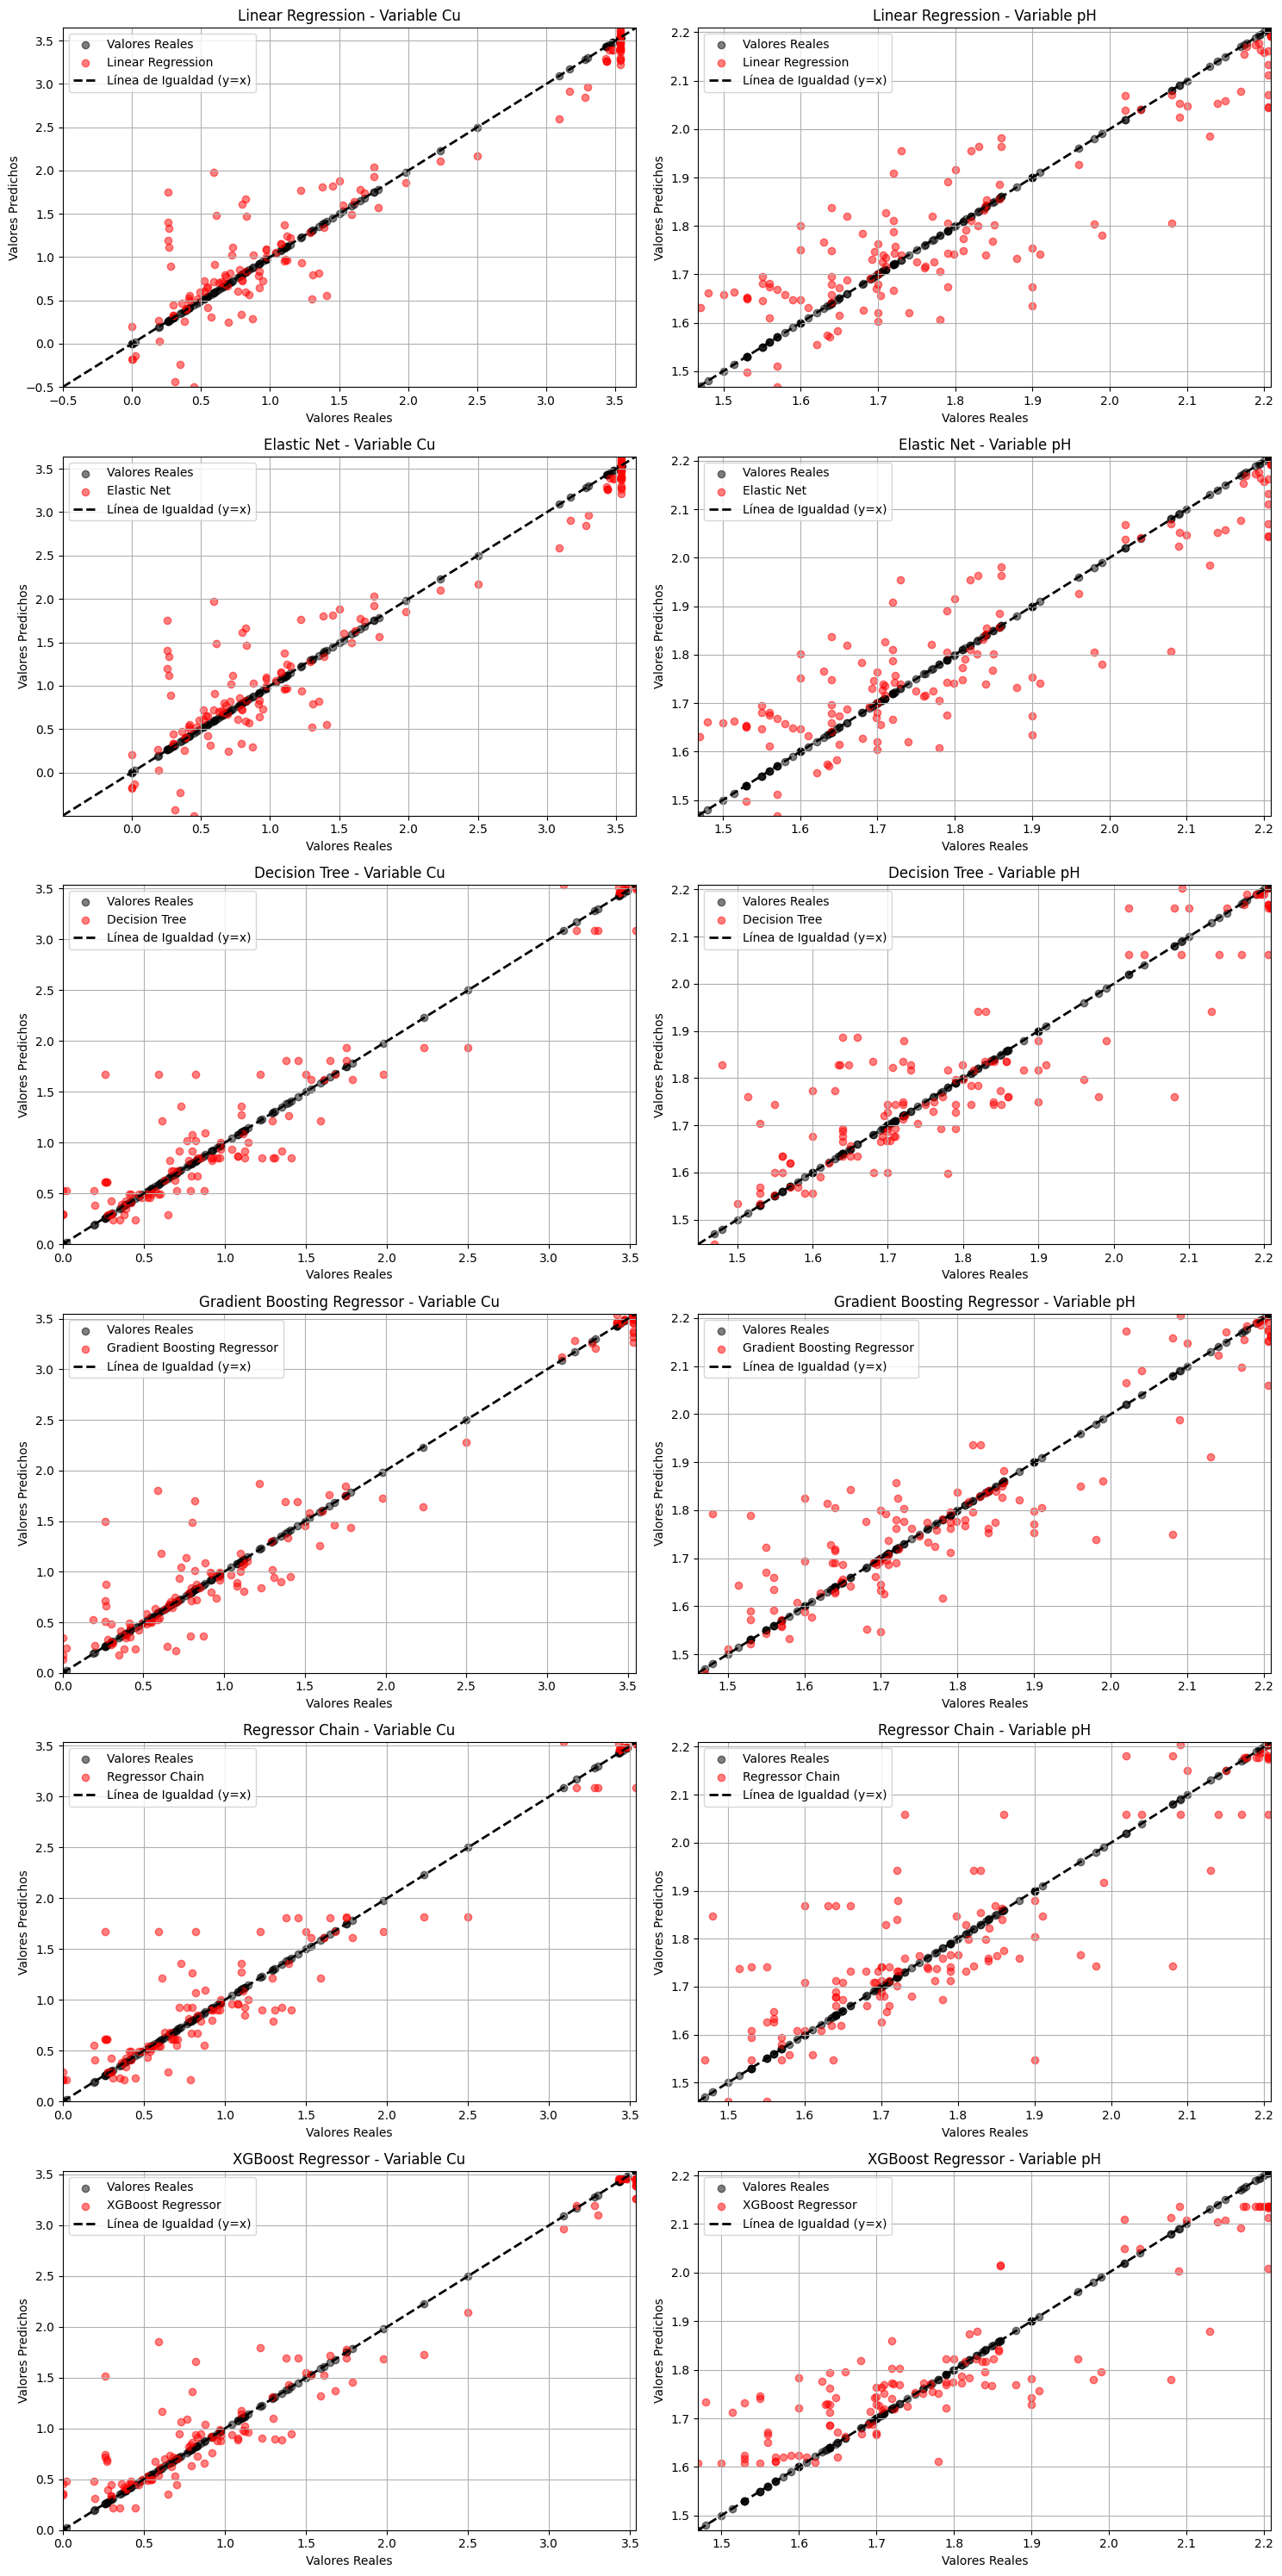

In [102]:
plot_predictions_per_model(y_real, predictions, model_names, variable_names)

### Gráficos de dispersión: Valores Reales vs Predicciones ver. 2

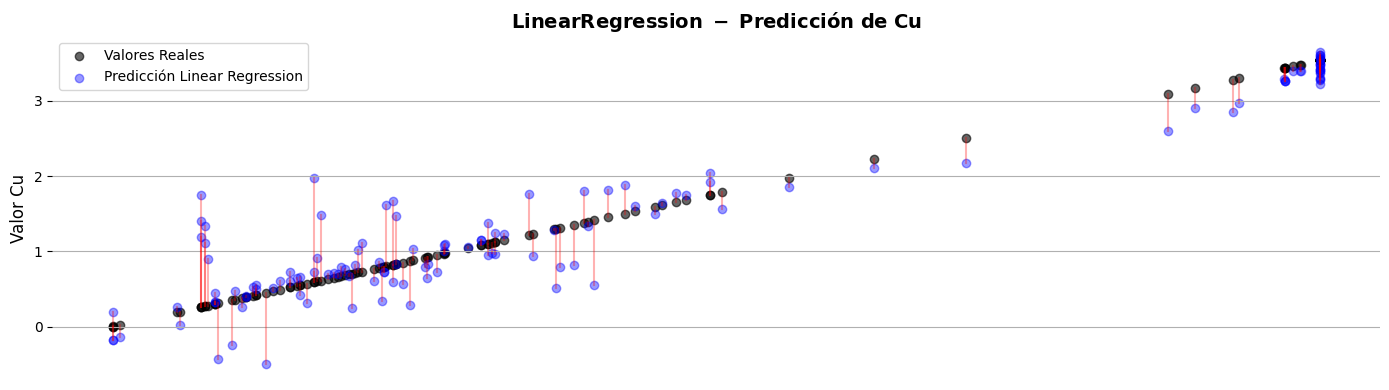

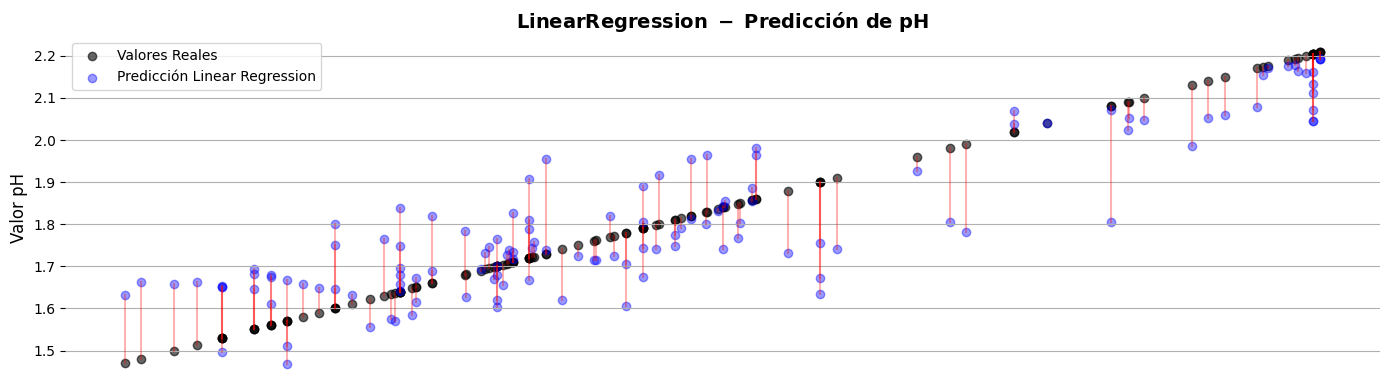

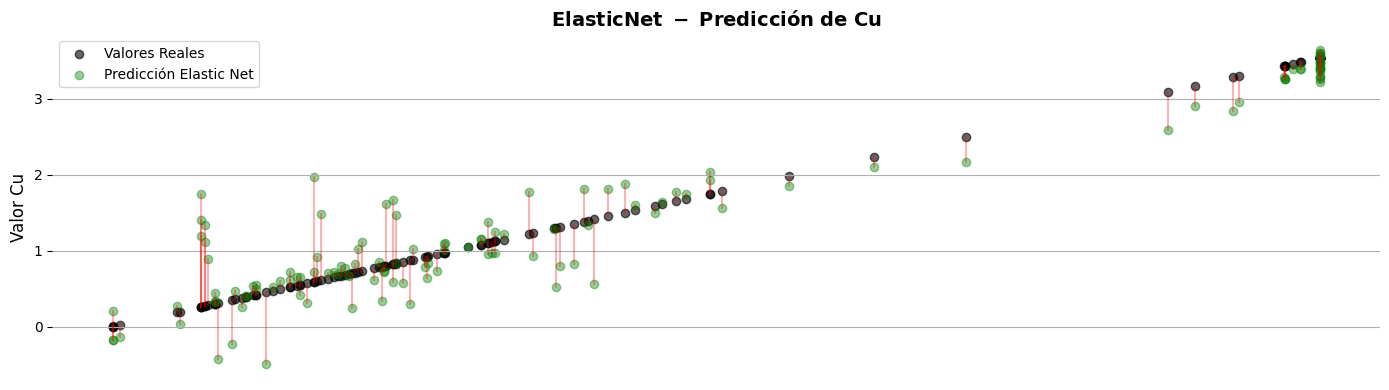

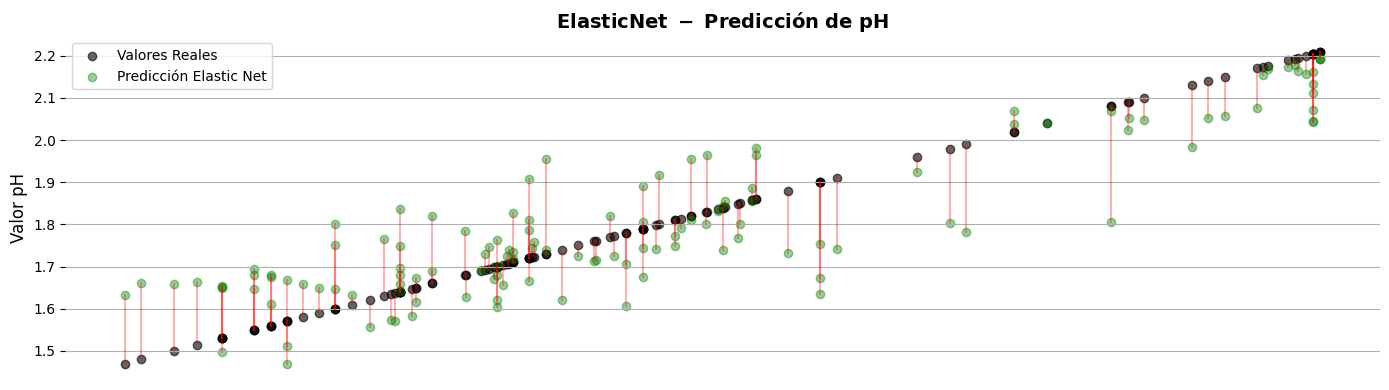

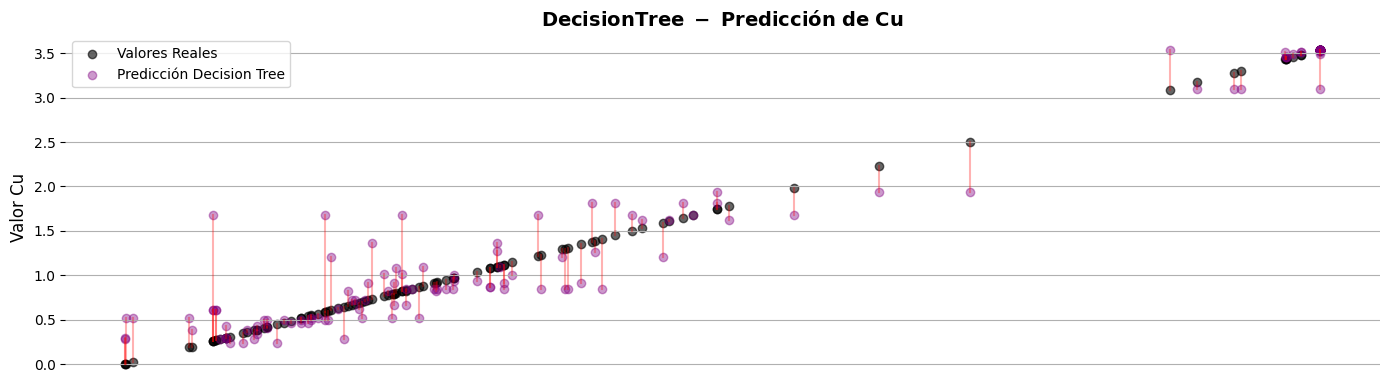

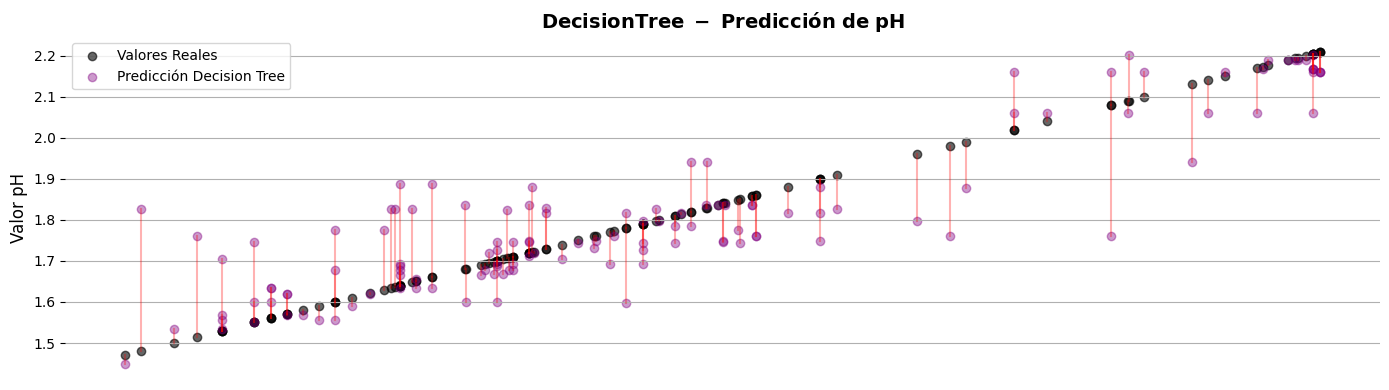

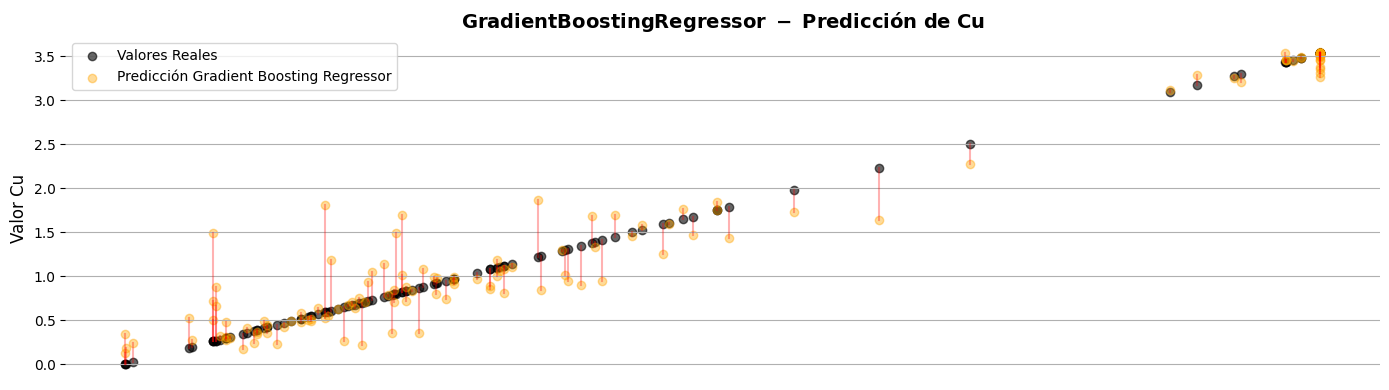

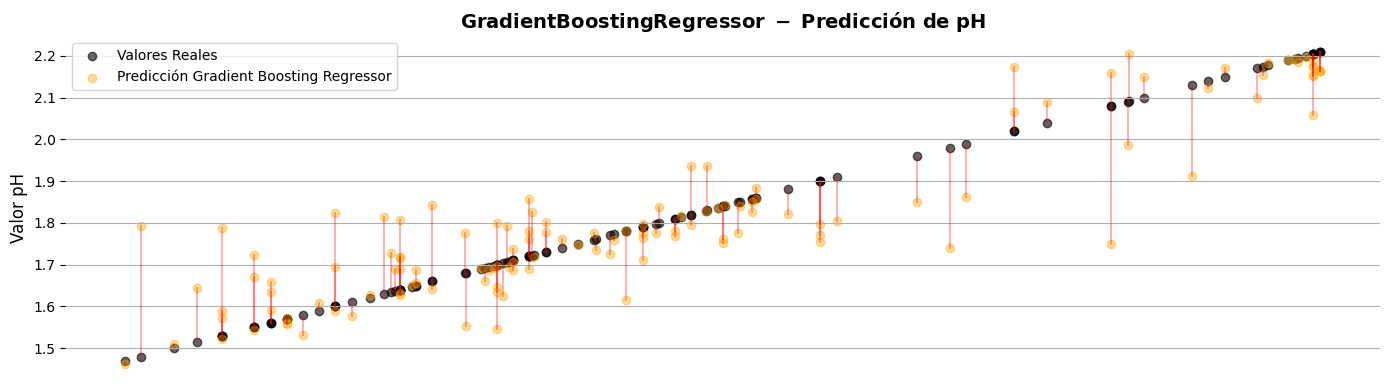

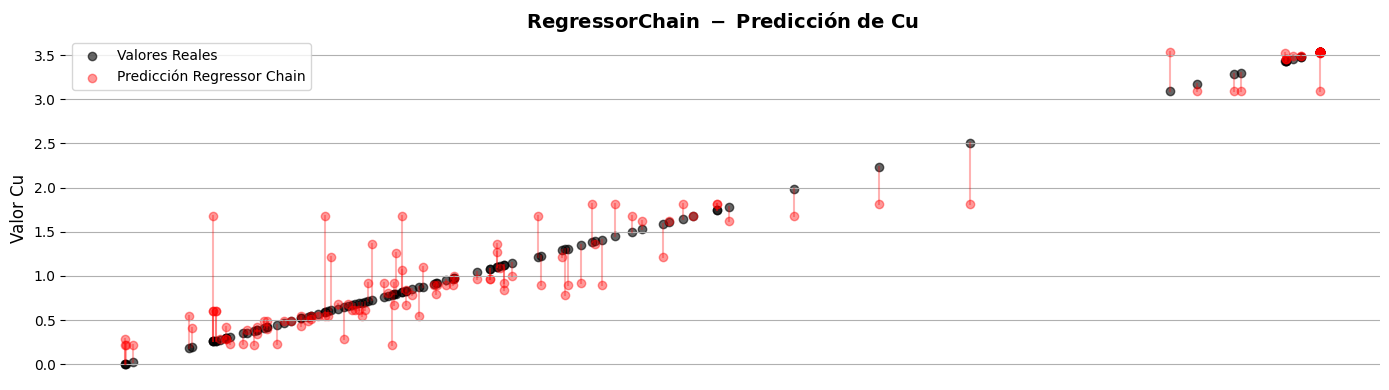

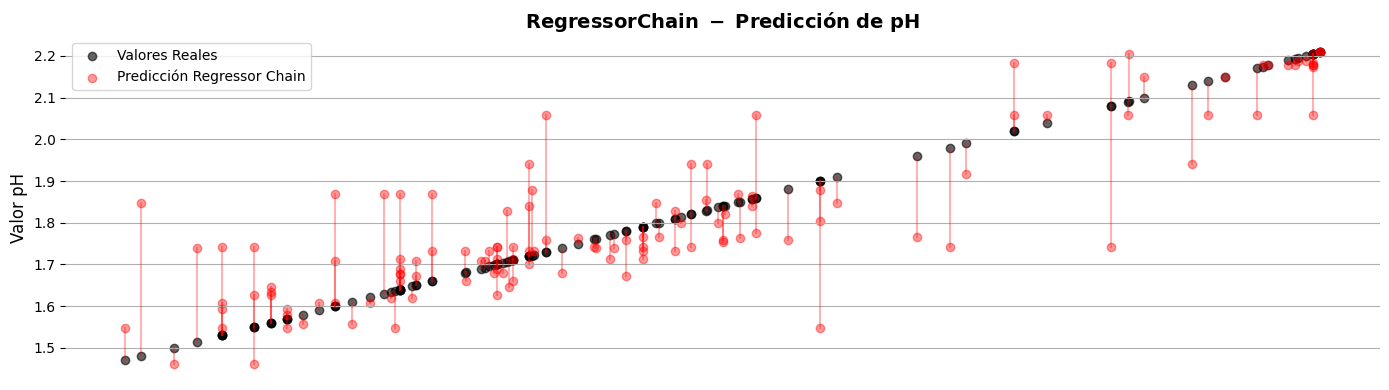

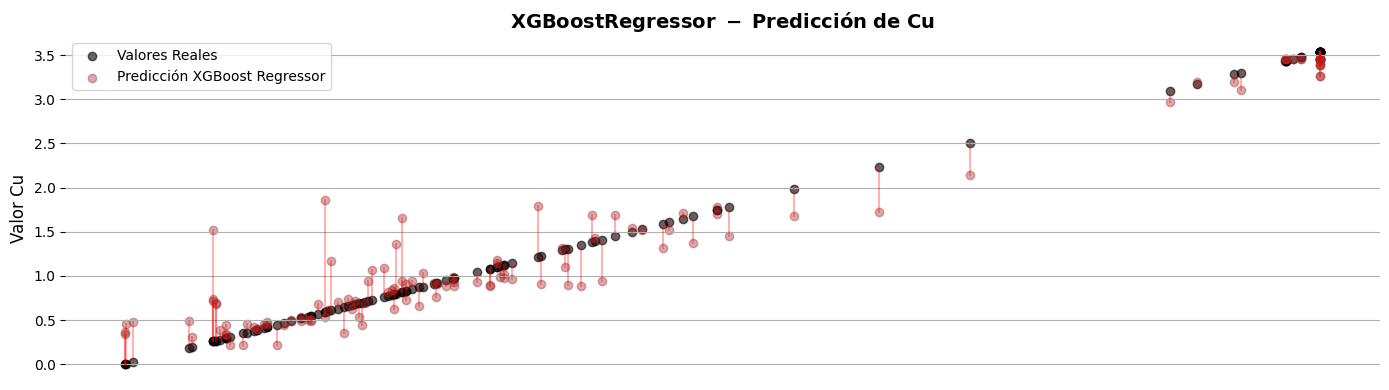

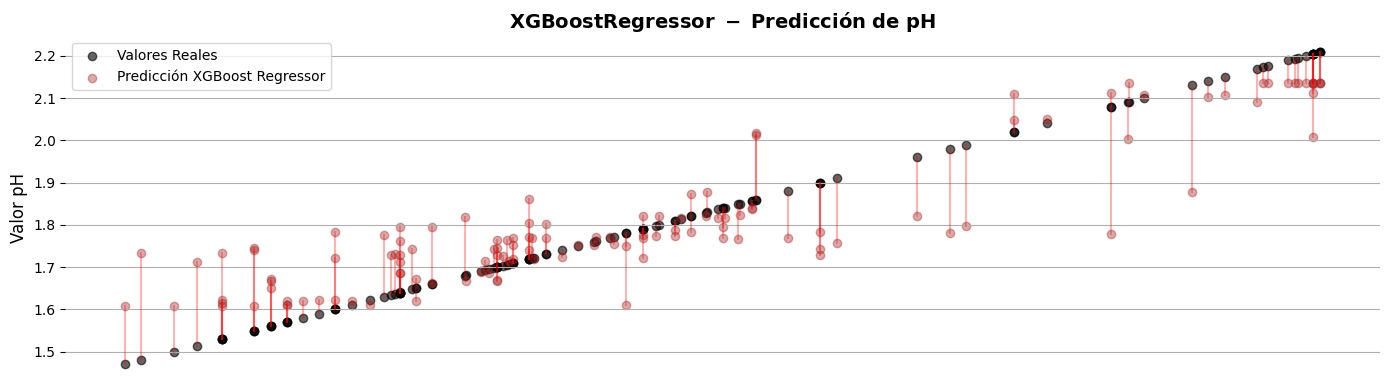

In [115]:
colors = {
    "Linear Regression": "blue",
    "Elastic Net": "green",
    "Decision Tree": "purple",
    "Gradient Boosting Regressor": "orange",
    "Regressor Chain": "red",
    "XGBoost Regressor": "brown"
}

for model_name in model_names:
    for var_index, var_name in enumerate(variable_names):
        plt.figure(figsize=(14, 4))
        
        sorted_indices = np.argsort(y_real[:, var_index])
        sorted_y_real = y_real[sorted_indices, var_index]
        sorted_predictions = predictions[model_name][sorted_indices, var_index]
        
        plt.scatter(sorted_y_real, sorted_y_real, 
                    color="black", 
                    label="Valores Reales", 
                    alpha=0.6)
        
        plt.scatter(sorted_y_real, sorted_predictions, 
                    color=colors[model_name],
                    label=f"Predicción {model_name}", 
                    alpha=0.4)
        
        for i in range(len(sorted_y_real)):
            plt.plot([sorted_y_real[i], sorted_y_real[i]], 
                     [sorted_y_real[i], sorted_predictions[i]], 
                     color="red", 
                     alpha=0.3)
        
        plt.title(f"$\\bf{{{model_name}\\ -\\ Predicción\\ de\\ {var_name}}}$",
                  fontsize=14)
        plt.ylabel(f"Valor {var_name}", 
                   fontsize=12)
        plt.grid(True)
        plt.box(False)
        plt.legend()
        plt.xticks([])  

        plt.tight_layout()
        plt.show()

---

# Documentación de modelos
En esta sección se documenta la elección de cada modelo entrenado, destacando sus características, funcionamiento y adecuación al caso de estudio.

---

## 1. Linear Regression

### Características del modelo:
- **Regresión Lineal** es uno de los métodos más simples y ampliamente utilizados para modelar relaciones entre una variable dependiente y una o más variables independientes.
- El modelo busca encontrar la mejor línea (o hiperplano en dimensiones más altas) que minimice el error entre los valores predichos y los reales.
- Se utiliza la versión multivariada del modelo mediante **MultiOutputRegressor**, que permite predecir múltiples variables dependientes de manera simultánea.

### Cómo funciona:
La **Regresión Lineal** ajusta una función de la forma:  
  
$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n + \epsilon $
  
  
Donde:
- $ y $ representa las variables dependientes (en este caso, múltiples variables a predecir).
- $ \beta_0 $ es el intercepto.
- $ \beta_1, \beta_2, ..., \beta_n $ son los coeficientes asociados a las variables independientes $ x_1, x_2, ..., x_n $.
- $ \epsilon $ es el término de error o ruido.

La versión multisalida con **MultiOutputRegressor** entrena un modelo de regresión lineal para cada una de las variables dependientes; en este caso, predecimos simultáneamente **`client_Cu`** y **`client_pH`**.

### Por qué se utiliza para este caso de estudio:
- El modelo es adecuado cuando hay una relación lineal entre las variables independientes y las variables objetivo.
- En este caso, es relevante ya que buscamos modelar cómo factores como la humedad, temperatura y pH afectan a los valores de **`client_Cu`** y **`client_pH`**, variables clave en los procesos de lixiviación.
- Al usar **MultiOutputRegressor**, se facilita la predicción de varias variables dependientes de forma simultánea, lo que es ventajoso en este caso, ya que ambos resultados pueden estar correlacionados.

### Ventajas del modelo:
- **Interpretabilidad**: Los coeficientes lineales son fácilmente interpretables, lo que permite entender cómo influye cada variable independiente en las predicciones.
- **Eficiencia computacional**: La regresión lineal es rápida y eficiente, lo que es ideal para conjuntos de datos de tamaño moderado como el de este proyecto.
- **Base para comparación**: Dado que es un modelo simple, se puede usar como una referencia para evaluar modelos más complejos.

### Limitaciones:
- El modelo asume que la relación entre las variables es lineal, lo que podría no ser completamente preciso en algunos escenarios complejos.
- No es robusto ante outliers ni ante relaciones no lineales.


---

## 2. Elastic Net

### Características del modelo:
- **Elastic Net** es un método de regresión que combina las propiedades de **Lasso** y **Ridge**, lo que permite seleccionar características mientras se controla la complejidad del modelo.
- Utiliza una combinación de penalización L1 (Lasso) y L2 (Ridge), lo que lo hace especialmente útil cuando hay muchas características correlacionadas.
- Al igual que la regresión lineal, se utiliza **MultiOutputRegressor** para predecir múltiples variables dependientes simultáneamente.

### Cómo funciona:
Elastic Net ajusta una función de la forma:  
  
$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n + \epsilon$
  

Donde:
- $ y $ representa las variables dependientes.
- $ \beta_0 $ es el intercepto.
- $ \beta_1, \beta_2, ..., \beta_n $ son los coeficientes asociados a las variables independientes $ x_1, x_2, ..., x_n $
- $ \epsilon $ es el término de error o ruido.

La penalización en Elastic Net se define como:  
  
$ \text{Penalización} = \alpha \sum_{j=1}^{n} |\beta_j| + \lambda \sum_{j=1}^{n} \beta_j^2 $

Donde:
- $ \alpha $ controla la fuerza de la penalización L1.
- $ \lambda $ controla la fuerza de la penalización L2.

**MultiOutputRegressor** permite que Elastic Net entrene un modelo para cada variable dependiente, como **`client_Cu`** y **`client_pH`**.

### Por qué se utiliza para este caso de estudio:
- Elastic Net es útil en situaciones con múltiples variables independientes que pueden estar correlacionadas, lo que es común en problemas de lixiviación donde diferentes factores (humedad, temperatura, pH) pueden interrelacionarse.
- Permite la regularización de los coeficientes, lo que ayuda a prevenir el sobreajuste y mejora la generalización del modelo a nuevos datos.
- Al utilizar **MultiOutputRegressor**, se facilita la predicción simultánea de las variables objetivo, lo que es ventajoso para evaluar la relación entre ellas.

### Ventajas del modelo:
- **Selección de características**: Puede seleccionar un subconjunto de variables relevantes para el modelo, lo que mejora la interpretabilidad.
- **Robustez**: Combina las ventajas de Lasso y Ridge, proporcionando robustez en la presencia de multicolinealidad.
- **Flexibilidad**: Permite ajustar el balance entre L1 y L2, lo que lo hace adaptable a diferentes problemas de modelado.

### Limitaciones:
- Al igual que otros modelos de regresión, Elastic Net puede verse afectado por la escala de las variables; es importante estandarizar los datos antes de su aplicación.
- La selección de hiperparámetros (como $ \alpha $ y $ \lambda $) puede requerir una validación cruzada cuidadosa para encontrar los valores óptimos.


---

## 3. Decision Tree Regressor

### Características del modelo:
- El **Regresor de Árbol de Decisión** es un modelo no paramétrico que utiliza una estructura de árbol para predecir el valor de una variable dependiente a partir de una o más variables independientes.
- El modelo divide el espacio de características en regiones más pequeñas mediante una serie de decisiones (o divisiones), lo que permite modelar relaciones complejas y no lineales entre las variables.
- Se utiliza el **MultiOutputRegressor** para predecir múltiples variables dependientes simultáneamente.

### Cómo funciona:
El Regresor de Árbol de Decisión realiza las siguientes operaciones:
1. **División**: El modelo elige una variable y un valor de umbral para dividir los datos en dos grupos. Este proceso se repite para cada grupo, creando una estructura de árbol.
2. **Criterio de división**: Utiliza un criterio como el **error cuadrático medio (MSE)** o el **error absoluto medio (MAE)** para determinar el mejor punto de división en cada nodo.
3. **Predicción**: Una vez que el árbol ha sido entrenado, las predicciones se realizan siguiendo las decisiones del árbol hasta llegar a una hoja, donde se calcula el valor medio de las observaciones en esa hoja.

### Por qué se utiliza para este caso de estudio:
- El modelo es especialmente útil en situaciones donde las relaciones entre las variables son complejas y no lineales, como en el caso de la lixiviación, donde diferentes factores pueden interactuar de maneras complejas.
- Permite manejar tanto variables categóricas como continuas sin necesidad de transformación previa, lo que simplifica el proceso de modelado.
- Al utilizar **MultiOutputRegressor**, se facilita la predicción de múltiples variables dependientes, como **`client_Cu`** y **`client_pH`**, que pueden estar correlacionadas.

### Ventajas del modelo:
- **Interpretabilidad**: Los árboles de decisión son fáciles de interpretar y visualizar, lo que permite entender cómo se toman las decisiones.
- **No requiere escalado de características**: Los árboles de decisión no son sensibles a la escala de las variables.
- **Flexibilidad**: Pueden capturar interacciones complejas entre las características sin requerir especificaciones previas.

### Limitaciones:
- **Sobreajuste**: Los árboles de decisión son propensos al sobreajuste, especialmente si no se aplican restricciones (como la profundidad máxima del árbol).
- **Inestabilidad**: Pequeños cambios en los datos pueden resultar en una estructura de árbol muy diferente, lo que puede afectar la robustez del modelo.


---

## 4. Gradient Boosting Regressor

### Características del modelo:
- El **Gradient Boosting Regressor** es un modelo de aprendizaje supervisado que utiliza la técnica de **boosting** para mejorar la precisión de las predicciones.
- Este modelo construye un conjunto de árboles de decisión de manera secuencial, donde cada nuevo árbol corrige los errores cometidos por los árboles anteriores.
- Se utiliza el **MultiOutputRegressor** para predecir múltiples variables dependientes simultáneamente.

### Cómo funciona:
El Gradient Boosting sigue estos pasos:
1. **Inicialización**: Comienza con una predicción inicial (generalmente la media de la variable objetivo).
2. **Cálculo de errores**: Calcula los errores de las predicciones actuales con respecto a los valores reales.
3. **Entrenamiento de un nuevo árbol**: Un nuevo árbol de decisión es entrenado para predecir estos errores, intentando capturar la estructura de los errores.
4. **Actualización de predicciones**: Las predicciones se actualizan sumando las predicciones del nuevo árbol, multiplicadas por un factor de aprendizaje (learning rate).
5. **Repetición**: Este proceso se repite durante un número definido de iteraciones (n_estimators), donde se entrenan múltiples árboles para mejorar la precisión.

### Por qué se utiliza para este caso de estudio:
- **Gradient Boosting** es efectivo en problemas donde hay interacciones complejas y no lineales entre las variables independientes y dependientes, como en la modelización de factores que afectan la lixiviación.
- Es capaz de manejar una variedad de tipos de datos y proporciona un buen rendimiento en tareas de regresión y clasificación.
- Al utilizar **MultiOutputRegressor**, permite predecir simultáneamente variables como **`client_Cu`** y **`client_pH`**, que pueden estar interrelacionadas.

### Ventajas del modelo:
- **Precisión**: Generalmente ofrece un rendimiento superior en comparación con modelos más simples debido a su capacidad para capturar patrones complejos.
- **Flexibilidad**: Puede adaptarse a diferentes tipos de datos y relaciones no lineales.
- **Control de sobreajuste**: Los hiperparámetros como la profundidad de los árboles y el learning rate permiten ajustar el modelo para prevenir el sobreajuste.

### Limitaciones:
- **Tiempo de entrenamiento**: El proceso de boosting puede ser más lento que otros métodos debido a la naturaleza secuencial del entrenamiento de árboles.
- **Hiperparámetros**: Requiere una cuidadosa selección de hiperparámetros, lo que puede complicar el proceso de modelado.
- **Interpretabilidad**: A pesar de que los modelos de boosting son más interpretables que los modelos de caja negra como las redes neuronales, siguen siendo menos transparentes que los árboles de decisión simples.


---

## 5. Regressor Chain

### Características del modelo:
- El **Regressor Chain** es un método para modelar problemas de predicción de múltiples variables dependientes, donde cada variable puede ser influenciada por las otras.
- Este enfoque entrena una serie de modelos de regresión de manera secuencial; cada modelo en la cadena predice una variable dependiente y puede usar las predicciones de los modelos anteriores como características adicionales.
- Se puede utilizar junto con cualquier modelo de regresión base, como árboles de decisión, regresión lineal o modelos de boosting.

### Cómo funciona:
El **Regressor Chain** sigue estos pasos:
1. **Entrenamiento secuencial**: Se entrena un modelo de regresión para la primera variable dependiente. Luego, se entrena el siguiente modelo, que utiliza las predicciones del modelo anterior como parte de su entrada.
2. **Predicción**: Para realizar predicciones, se comienza con el primer modelo de la cadena, se predice la primera variable dependiente y se utiliza esa predicción para predecir la siguiente variable en la cadena, y así sucesivamente.
3. **Flujo de información**: Este flujo de información permite que el modelo capture las interdependencias entre las variables dependientes.

### Por qué se utiliza para este caso de estudio:
- El enfoque de **Regressor Chain** es útil en situaciones donde las variables dependientes están correlacionadas. En el caso de la lixiviación, factores como **`client_Cu`** y **`client_pH`** pueden influirse mutuamente.
- Este método permite que la predicción de una variable dependa no solo de las características de entrada, sino también de las predicciones de otras variables dependientes, mejorando así la precisión global del modelo.

### Ventajas del modelo:
- **Captura de interdependencias**: Permite modelar relaciones complejas entre variables dependientes, lo que puede llevar a mejores resultados en comparación con modelos que las tratan de forma independiente.
- **Flexibilidad**: Puede combinarse con diferentes regresores base, lo que permite adaptar el modelo a las necesidades específicas del problema.
- **Mejora en la precisión**: En problemas con variables dependientes interrelacionadas, este enfoque puede superar a los modelos que no consideran estas relaciones.

### Limitaciones:
- **Complejidad**: El modelo puede volverse complejo y difícil de interpretar, ya que la predicción de cada variable depende de múltiples modelos.
- **Tiempo de entrenamiento**: Puede ser más lento en comparación con métodos que no utilizan una cadena, debido a la necesidad de entrenar múltiples modelos secuencialmente.
- **Dependencia de los datos**: La calidad de las predicciones depende de la calidad de las predicciones anteriores en la cadena, lo que puede propagar errores si un modelo en la cadena no funciona adecuadamente.


## XGBoost Regressor

### Características del modelo:  
- El **XGBoost Regressor** es un modelo de aprendizaje supervisado que utiliza técnicas avanzadas de boosting para optimizar la precisión de las predicciones.
- Este modelo construye múltiples árboles de decisión de manera secuencial, donde cada nuevo árbol se ajusta para corregir los errores de los árboles previos, mejorando así la capacidad de predicción.
- Incorpora regularización, lo que lo hace menos propenso al sobreajuste en comparación con otros modelos de boosting.
- Se utiliza el **MultiOutputRegressor** para predecir múltiples variables dependientes al mismo tiempo.  
  
### Cómo funciona:  
El **XGBoost** sigue estos pasos:  
1. **Inicialización:** Comienza con una predicción inicial (comúnmente la media de la variable objetivo).
2. **Cálculo de errores:** Evalúa los errores de las predicciones actuales en relación con los valores reales.
3. **Entrenamiento de nuevos árboles:** Entrena nuevos árboles de decisión que se centran en los errores actuales, buscando mejorar las predicciones.
4. **Actualización de predicciones:** Las predicciones se actualizan sumando las salidas de los nuevos árboles, cada uno multiplicado por un factor de aprendizaje (learning rate).
5. **Repetición:** Este proceso se repite para un número específico de iteraciones (n_estimators), lo que permite entrenar múltiples árboles para alcanzar una alta precisión.  
  
**Por qué se utiliza:**  
- **XGBoost** es altamente efectivo en escenarios donde las relaciones entre las variables son complejas y no lineales, como es el caso de los factores que influyen en la lixiviación.  
- Ofrece un rendimiento robusto en tareas de regresión y clasificación, manejando bien diferentes tipos de datos.  
- Al emplear **MultiOutputRegressor**, facilita la predicción simultánea de variables como client_Cu y client_pH, que pueden estar correlacionadas y son relevantes para el estudio.  
  
**Ventajas del modelo:**  
- **Precisión:** Su enfoque avanzado de boosting suele superar el rendimiento de modelos más simples al captar patrones complejos en los datos.
- **Eficiencia:** Utiliza optimizaciones para el entrenamiento, lo que resulta en un uso eficiente de los recursos y una reducción en el tiempo de entrenamiento.  
- **Control de sobreajuste:** Integra regularización, lo que ayuda a mitigar el sobreajuste y mejora la generalización en datos no vistos.  
  
**Limitaciones:**  
- **Complejidad:** Aunque XGBoost es poderoso, también puede ser más complicado de ajustar debido a la cantidad de hiperparámetros que requieren atención.
- **Tiempo de entrenamiento:** Aunque más eficiente que otros métodos de boosting, el tiempo de entrenamiento puede ser significativo, especialmente con grandes conjuntos de datos.
- **Interpretabilidad:** Aunque más interpretable que las redes neuronales, sigue siendo menos transparente que modelos simples como los árboles de decisión, lo que puede dificultar la comprensión de sus decisiones.